---
project:
  type: default

format:
  html:
    theme:
      light: cosmo
      dark: darkly

    toc: true
    toc-depth: 3
    number-sections: true

    code-fold: true
    code-summary: "Show / Hide code"
    code-overflow: wrap
    
    embed-resources: true
---


# For course instructors

Whole project is available on [github](https://github.com/maxi7524/SAD2_final_project) where is readme with instruction how install dependencies.

Data which we generated and used, can be download from script (readme): 
```shell
bash scripts/download_and_unzip_report_data.sh
```
or be directly accessed on [google drive](https://drive.google.com/drive/folders/1fbIJiBIGMP9HivtoPEkko7hT6t2mXH0n?fbclid=IwY2xjawPkSbtleHRuA2FlbQIxMQBzcnRjBmFwcF9pZAEwAAEeeGVO2xSm_ZYKfOcl1NswUrAK5gGbMfuvn9tYDFeomyfS9i9nIgccMeW8Ooo_aem_mPHWJ7MRVySCLerEKXC-4g).

To run script you only need to run `uv` and download data


In [ ]:
# libraries
## system
from pathlib import Path
import os
## data manipulation
import pandas as pd
import numpy as np
## analysis
import statsmodels.formula.api as smf
## plots
import seaborn as sns
import matplotlib.pyplot as plt

## local library
### load data
from sad2_final_project.analysis import loader_obsolete_data, experiment_data_loader, add_missing_metrics_from_experiment, analyze_datasets_from_index
### general plots
from sad2_final_project.analysis import plot_scatter, plot_scatter_subplots, plot_boxplot, plot_grouped_boxplots
### Statistical analysis and associated plots
from sad2_final_project.analysis import compute_spearman_table, plot_spearman_heatmap, compute_wilcoxon_table, plot_wilcoxon_heatmap
# Path management
## set cwdir to repository folder 
cwd=Path.cwd()
if cwd.name == "notebooks":
    os.chdir(cwd.parent)
print(os.getcwd())


## create paths
DATA_PATH = Path('data')
DATASET_1_PATH = DATA_PATH / Path('experiment_12_merged')
DATASET_2_S_PATH = DATA_PATH / Path('experiment_34_synchronous_merged')
DATASET_2_A_PATH = DATA_PATH / Path('experiment_34_asynchronous_merged')

In [ ]:
# Data loading 
## Dataset 1 - experiments 1, 2
### load with column drop
df = experiment_data_loader(DATASET_1_PATH).drop(columns=['attractor_ratio_y'])
### rename columns
df = df.rename(columns={'attractor_ratio_x': 'attractor_ratio'})
## Dataset 2 - experiments 3, 4
dfs = experiment_data_loader(DATASET_2_S_PATH).drop(columns=['part_x', 'part_y'])
dfa = experiment_data_loader(DATASET_2_A_PATH).drop(columns=['part_x', 'part_y'])

## Add all metrics
metrics_list=['TP', 'FP', 'FN', 'f1', 'accuracy', 'precision', 'recall', 'sensitivity', 'AHD', 'SHD', 'EHD', 'SID']
df = add_missing_metrics_from_experiment(df, DATASET_1_PATH, metrics_list, after_column='attractor_ratio')
dfs = add_missing_metrics_from_experiment(dfs, DATASET_2_S_PATH, metrics_list, after_column='attractor_ratio')
dfa = add_missing_metrics_from_experiment(dfa, DATASET_2_A_PATH, metrics_list, after_column='attractor_ratio')
df1 = df[df["trajectory_length"]>=10] # dataset1


# Introduction 
## Goal
The goal of this study is to investigate the relation between **sampling strategy** and **model selection metrics** in *boolean Bayesian networks (BDNs)* using `BNFinder2`. 

In particular, we analyze how characteristics of time-series data generated from Boolean networks influence the accuracy of reconstructing the underlying network structure using Bayesian methods. The experimental factors under investigation include:

- the **trajectory length**,
- the **sampling frequency**, defined as selecting every $n$-th state along a trajectory,
- the ratio between the **number of nodes** and the **trajectory length**, introduced as a normalization parameter $k$.

The generated datasets are grouped into classes determined by:

- the **update mode** (synchronous vs asynchronous),
- the **scoring function** used during inference (MDL and BDe).

In addition, we study **scaling relations with respect to the number of nodes**, aiming to characterize how data requirements and reconstruction accuracy change as network size increases.

# Part 1

## Methodology

### Experimental design


#### Update Mode
We distinguish between two fundamentally different update mechanisms:

- **Synchronous update**, which defines a deterministic dynamical system: from any given state, the successor state is uniquely determined.
- **Asynchronous update**, which induces a stochastic process: at each time step, a randomly selected node is updated, leading to multiple possible successor states.

This distinction is critical, as asynchronous dynamics introduce temporal dependence and potential autocorrelation in trajectories. In particular, long residence times in attractors or local cycles may reduce the effective information content of sampled data. Consequently, naive dense sampling may lead to strongly correlated observations, while aggressive subsampling may destroy causal ordering information.

***

#### Scoring Functions
We employ two scoring functions implemented in BNFinder2, which differ in how they trade off data fit against model complexity.
Let $G$ denote a candidate network structure and $D$ the observed dataset.

**Minimal Description Length (MDL)**

The MDL score is defined as
$$
\mathrm{MDL}(G \mid D)
= - \log P(D \mid G, \hat{\theta})
\times \frac{1}{2} , |\theta_G| , \log |D|,
$$


where $\hat{\theta}$ are maximum-likelihood parameters and $|\theta_G|$ denotes the number of free parameters implied by the graph structure $G$.

The first term rewards goodness of fit, while the second term penalizes model complexity. As a consequence, MDL favors simpler graphs when data are scarce and becomes less restrictive as sample size increases. This makes MDL particularly sensitive to undersampling and normalization effects.

**Bayesian–Dirichlet equivalence (BDe)**

The BDe score evaluates the marginal likelihood

$$
\mathrm{BDe}(G \mid D)
= - \log \int P(D \mid G, \theta), P(\theta \mid G), d\theta,
$$

assuming a Dirichlet prior over conditional probability tables. Under standard assumptions, this integral has a closed-form.

Unlike MDL, BDe incorporates prior beliefs and smooths parameter estimates, which can stabilize inference in low-data regimes but may also reduce sensitivity to subtle structural differences.

By comparing MDL and BDe, we assess whether observed reconstruction effects are driven primarily by data properties or by the inductive bias of the scoring function.

One caveat is that our implementation of those functions is simplified compared to implemented in BNfinder, value obtained is different but monotonicity is preserved and therefore do not affect the validity of our conclusions.

***

#### Evaluation Metrics
Reconstruction quality is evaluated using structure-based graph distance measures. Each metric captures a distinct notion of discrepancy between the true network $G^\ast$ and the inferred network $\hat{G}$. 

**Adjusted Hamming Distance (AHD)**

Let $A^\ast$ and $\hat{A}$ denote the adjacency matrices of $G^\ast$ and $\hat{G}$. The adjusted Hamming distance is defined as

$$
\mathrm{AHD}(G^\ast, \hat{G})
= \frac{1}{|E^\ast| + |\hat{E}|}
\sum_{i,j} \mathbf{1}_{{A^\ast_{ij} \neq \hat{A}_{ij}}}.
$$
AHD measures the proportion of mismatched edges, normalized by graph size and allows comparisons across networks of different sizes. This metric serves as the primary measure of structural accuracy.

**Structural Hamming Distance (SHD)**

SHD counts the minimum number of edge insertions, deletions, or reversals required to transform $\hat{G}$ into $G^\ast$.
$
\mathrm{SHD}(G^\ast, \hat{G}) \in \mathbb{N}.
$
While widely used, SHD aggregates heterogeneous error types and does not distinguish between missing, extra, or misoriented edges, limiting its interpretability.

**Structural Intervention Distance (SID)**

SID measures the number of node pairs $(i,j)$ for which the causal effect of intervening on $i$ differs between $G^\ast$ and $\hat{G}$.

$$
\mathrm{SID}(G^\ast, \hat{G})
= \left| {(i,j) : P(j \mid \mathrm{do}(i))*{G^\ast}
\neq P(j \mid \mathrm{do}(i))*{\hat{G}} } \right|.
$$
Where $\mathrm{do}(i=n)$ set node $i$ to have value $n$ at time step, regardles of Boolean update rule.

SID is sensitive to edge orientation and captures errors that affect causal interpretability, even when the undirected structure is largely correct.

Using these metrics jointly allows us to separate purely topological accuracy (AHD, SHD) from correctness of implied causal relationships (SID) and to identify metric-specific effects of sampling and model selection.
***

#### Independence
To avoid introducing structural bias, Boolean networks are generated randomly for each condition:

- each node is assigned a random number of parents (uniformly chosen from $\{ 1 ,2 ,3 \}$),
- Boolean update functions are sampled randomly.
All generated networks are accepted without filtering. Repetitions under identical conditions are treated as independent realizations.

***


#### Sample Size Normalization
To ensure comparability across networks of different sizes, we introduce **sample-size normalization**.
Let:

- $n_{\text{nodes}}$​ denote the number of nodes,
- $T_{\text{length}}$​ the trajectory length,
- $k$ a normalization constant.

The total number of sampled time points is defined as:
$$
\begin{align}
T_{\text{amount}} & = \frac{{n_{\text{nodes}} \cdot k}}{T_{\text{length}}} 
\end{align}
$$

We fix $k=100$. This choice is motivated by the fact that each node with at most three parents has up to $2^3 = 8$ possible parent-state configurations. Setting $k=100$ corresponds to approximately 10 observations per configuration per node, providing a conservative buffer against stochastic effects and subsampling losses.
***

### Dataset Construction

#### General Settings
Across all experiments, we vary the following parameters:

* number of nodes (`num_nodes`): ([5, 7, 11, 13, 15]),
* scoring function (`score_function`): MDL, BDe,
* update mode (`update_mode`): synchronous, asynchronous,
* parent count per node: randomly chosen from ({1,2,3}),
* number of repetitions per condition: 30.

***

#### Dataset 1 (Baseline Dataset)
This dataset is used in Experiments 1 and 2.

* trajectory length (`trajectory_length`): ([10, 15, 20, 30, 40, 50]),
* sampling frequency (`sampling_frequency`): ([1, 2, 3, 4, 5]),
* number of trajectories: determined via sample-size normalization.

***

#### Dataset 1.1 (Low-Data Regime)
To probe behavior in extreme data-scarce settings, an auxiliary dataset is constructed with:

* trajectory length: ([5, 7, 9]),
* number of nodes: ([5, 7, 9]),
* sampling frequency: ([1, 2, 3, 4, 5]).
This dataset is included to assess scaling behavior when normalization constraints are tight.

***

#### Dataset 2 (Normalization Study)
Using optimal parameters identified in Experiments 1 and 2, we fix:

$$\begin{align*} \text{sampling frequency} & =\begin{cases}1  & \text{synchronous} \\ 2 & \text{asynchronous and MDL} \\ 3 & \text{asynchronous and BDE}\end{cases} & \mathrm{trajectory\ length}=[0.8 \cdot x]_{\mathrm{round}}\end{align*}$$

We then vary the normalization constant:
$$k \in \{20, 40, 60, 80, 100, 120, 140\}$$

***





### Experiments procedures
#### Experiment 1: Attractor Prevalence and Trajectory Length
Motivated by prior observations that attractor-heavy datasets degrade reconstruction quality, we investigate:
1. the correlation between attractor fraction and reconstruction metrics,
2. how attractor prevalence depends on trajectory length,
3. how these effects scale with network size.
We introduce the **scale ratio**
$$\text{scale ratio} = \frac{T_{\text{length}}}{n_{\text{nodes}}}$$
and analyze its relationship with attractor fraction to identify regimes that balance coverage of transient dynamics and attractor exploration.

***

#### Experiment 2: Subsampling and Temporal Dependence
The goal of this experiment is to identify an appropriate subsampling parameter by:

0. Reducing the effective amount of data via subsampling.
1. Examining a possible relationship between *data characteristics*, quantified using **lag-1 autocorrelation (ACF)** and **effective sample size (ESS)**.
2. Examining a possible relationship between data characteristics and reconstruction quality.
3. Assessing statistical significance of the relationship between data characteristics and reconstruction quality by evaluating **Spearman correlation tests** between ESS / ACF and reconstruction metrics, within groups defined by  
   (`num_nodes`, `update_mode`, `score_function`, `sampling_frequency`).
4. Assessing statistical significance of the relationship between **sampling frequency** and **reconstruction quality** by evaluating **Wilcoxon tests** on **AHD** and **SID** metrics for consecutive subsampling levels $(i \rightarrow i+1)$, within groups defined by   
   (`num_nodes`, `update_mode`, `score_function`).

This experiment concludes with the identification of optimal subsampling parameters as a function of `update_mode` and `score_function`.

***

#### Experiment 3: Normalization and Information Saturation
Fixing sampling parameters based on earlier results, we analyze how reconstruction metrics evolve as a function of the normalization constant ($k$). This allows us to identify saturation regimes in which increasing sample size yields diminishing returns.

***

#### Experiment 4: Score Function Sensitivity
Finally, using a subset of Experiment 3 with fixed normalization, we investigate how reconstruction metrics depend on the choice of scoring function. The goal is to understand whether differences in reconstruction quality arise from data properties or from intrinsic characteristics of the scoring criteria.

## Analysis

### Experiment 1 

#### Determinants of Reconstruction Accuracy

The primary objective of this analysis was to identify the key factors influencing the accuracy of Boolean network reconstruction using dynamic Bayesian networks (DBNs). Specifically, we investigated how properties of the generated data (attractor ratio, trajectory length), network characteristics (number of nodes), and inference configuration (update mode and scoring function) affect reconstruction quality as measured by standard performance metrics.

##### Exploratory Correlation Analysis

We first conducted a pairwise correlation analysis between data characteristics and reconstruction metrics (precision, recall, SHD, and AHD). 

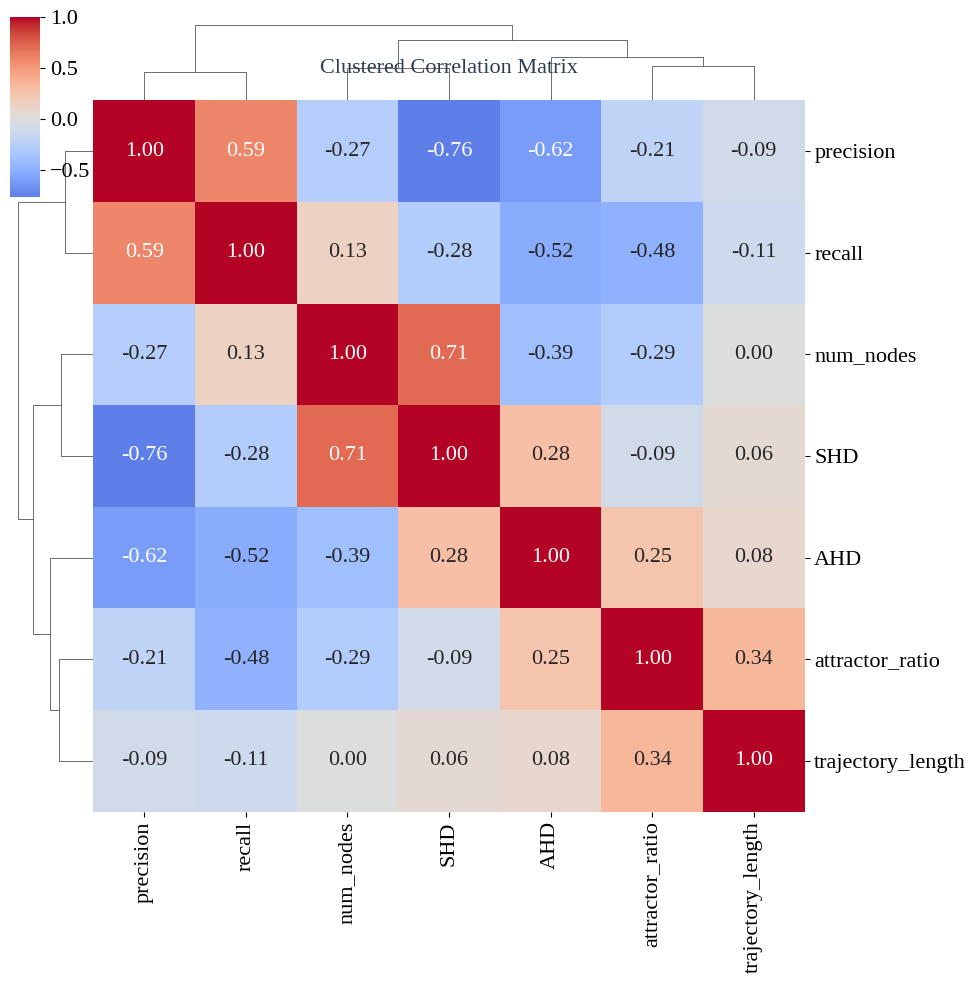

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df1[['attractor_ratio', 'num_nodes', 'trajectory_length', 'precision', 'recall', 'SHD', 'AHD']].corr(method='spearman')
g = sns.clustermap(corr_matrix, 
                   annot=True, 
                   cmap="coolwarm",
                   fmt=".2f",
                   figsize=(10, 10),
                   row_cluster=True,
                   col_cluster=True,
                   center=0,
                   dendrogram_ratio=0.1,
                   cbar_pos=(0.02, 0.8, 0.03, 0.18))
g.ax_heatmap.set_title("Clustered Correlation Matrix", fontsize=16, pad=20)
plt.show()

This exploratory step revealed several notable relationships:

- **Attractor ratio** exhibited a strong negative correlation with recall (r = –0.48), indicating that datasets dominated by attractor states substantially impair the recovery of true regulatory interactions.
- **Network size (number of nodes)** showed a strong positive correlation with SHD (r = 0.71), confirming that reconstruction error increases with network complexity.
- **Trajectory length** displayed near-zero correlations with all performance metrics, suggesting that its effect is not uniform and likely depends on interactions with other factors.


***


#### Multivariate Regression Analysis

To quantify the independent contribution of each factor while controlling for others, we fitted ordinary least squares (OLS) regression models for structural error (SHD) and adjacency error (AHD). The primary model for SHD included attractor ratio, trajectory length, number of nodes, update mode, scoring function, and an interaction between attractor ratio and trajectory length:

```
SHD ~ attractor_ratio × trajectory_length + num_nodes + update_mode + score_function
```


In [4]:
model = smf.ols(
    "SHD ~ attractor_ratio * trajectory_length + num_nodes + update_mode + score_function",
    data=df1
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SHD   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     2332.
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        08:04:09   Log-Likelihood:                -71233.
No. Observations:               18000   AIC:                         1.425e+05
Df Residuals:                   17993   BIC:                         1.425e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

The model explained approximately 44% of the variance in SHD (R² ≈ 0.44), indicating substantial explanatory power. The following effects were statistically significant:

- **Attractor ratio** had a strong positive effect on SHD, demonstrating that a higher proportion of attractor states in the data leads to increased structural reconstruction error.
- **Update mode** (synchronous vs. asynchronous) exerted a large effect, with synchronous updates yielding significantly higher error. This result was expected, as synchronous dynamics reduce the diversity of observable transitions, effectively decreasing the informational content of the data.
- **Scoring function** had a strong effect, with MDL outperforming BDe in terms of lower structural error.
- **Trajectory length** had a smaller but statistically significant effect on SHD, indicating that longer trajectories do not necessarily improve reconstruction accuracy under fixed sample size conditions.

***


#### Interaction Effects and Mechanistic Insight

To further investigate how data characteristics interact, we fitted a second regression model for adjacency error (AHD) including the interaction term:

```
AHD ~ attractor_ratio × trajectory_length + num_nodes + update_mode + score_function
```

In [5]:
model2 = smf.ols(
    "AHD ~ attractor_ratio * trajectory_length + num_nodes + update_mode + score_function",
    data=df1
).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    AHD   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     832.7
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        08:04:09   Log-Likelihood:                 10722.
No. Observations:               18000   AIC:                        -2.143e+04
Df Residuals:                   17993   BIC:                        -2.138e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

This model revealed a significant negative interaction between attractor ratio and trajectory length, indicating that longer trajectories partially mitigate the detrimental effect of high attractor dominance. In other words, while attractor-heavy datasets are generally less informative, increasing trajectory length can partially compensate by providing more opportunities to observe transient dynamics.

***


#### Summary of Determinants

Overall, reconstruction accuracy was primarily influenced by:

1. **Update mode**, which strongly affected performance due to differences in the stochasticity and informational richness of the generated trajectories. This effect is intuitive, as reduced dynamical variability limits the ability to infer causal relationships.
2. **Scoring function**, with MDL consistently outperforming BDe under the studied conditions.
3. **Attractor ratio**, which emerged as the most influential data-related factor, particularly impairing recall and increasing structural error.
4. **Network size**, which substantially increased structural error due to scaling complexity.
5. **Trajectory length**, which had a secondary, interaction-dependent effect rather than a uniform influence.

These findings demonstrate that reconstruction accuracy is jointly determined by data composition, network complexity, and inference configuration, with attractor dominance playing a central role in limiting the informativeness of time-series data.

#### Visualizing the Impact of Attractor Ratio on Reconstruction Error

To complement our regression analysis and gain an intuitive understanding of how **attractor dominance interacts with scoring function and update mode**, we generated scatter plots of **SHD, AHD, BDe and MDL versus attractor ratio**, stratified by **synchronous and asynchronous updates**.

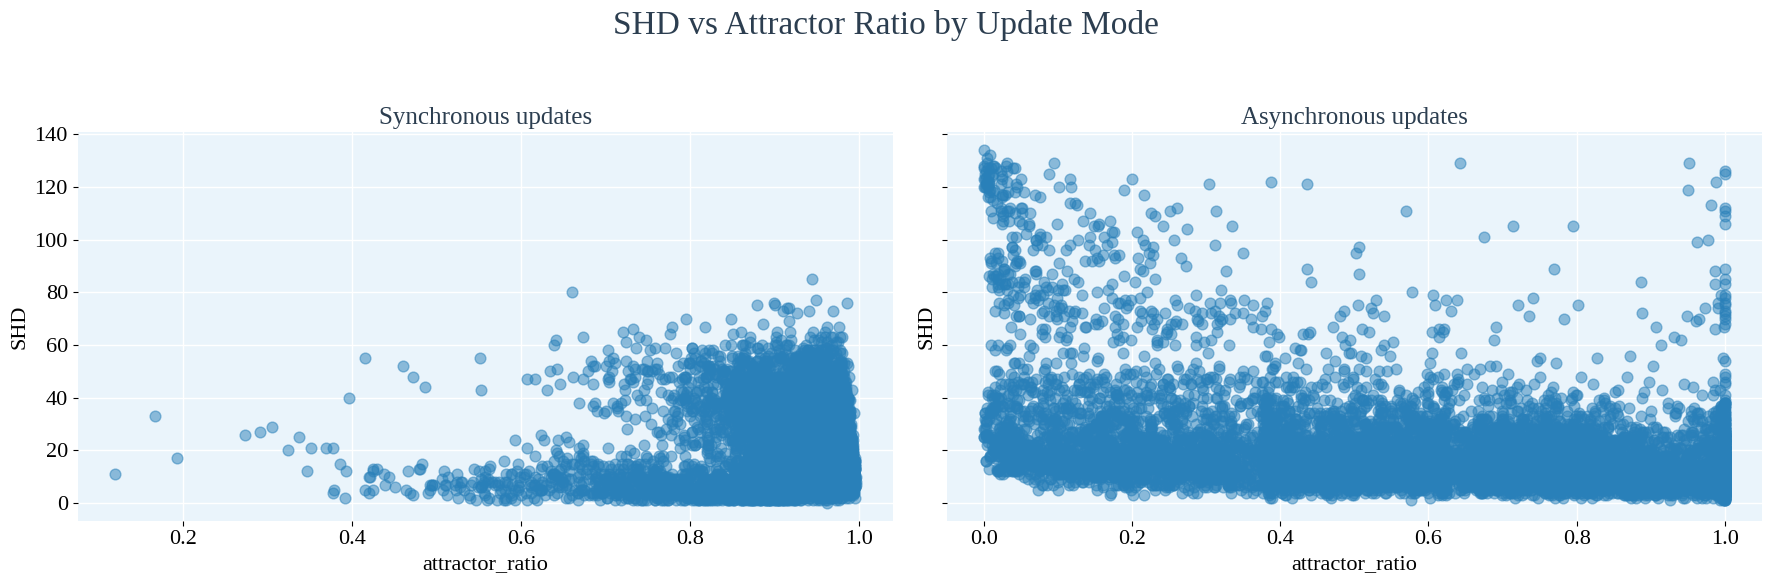

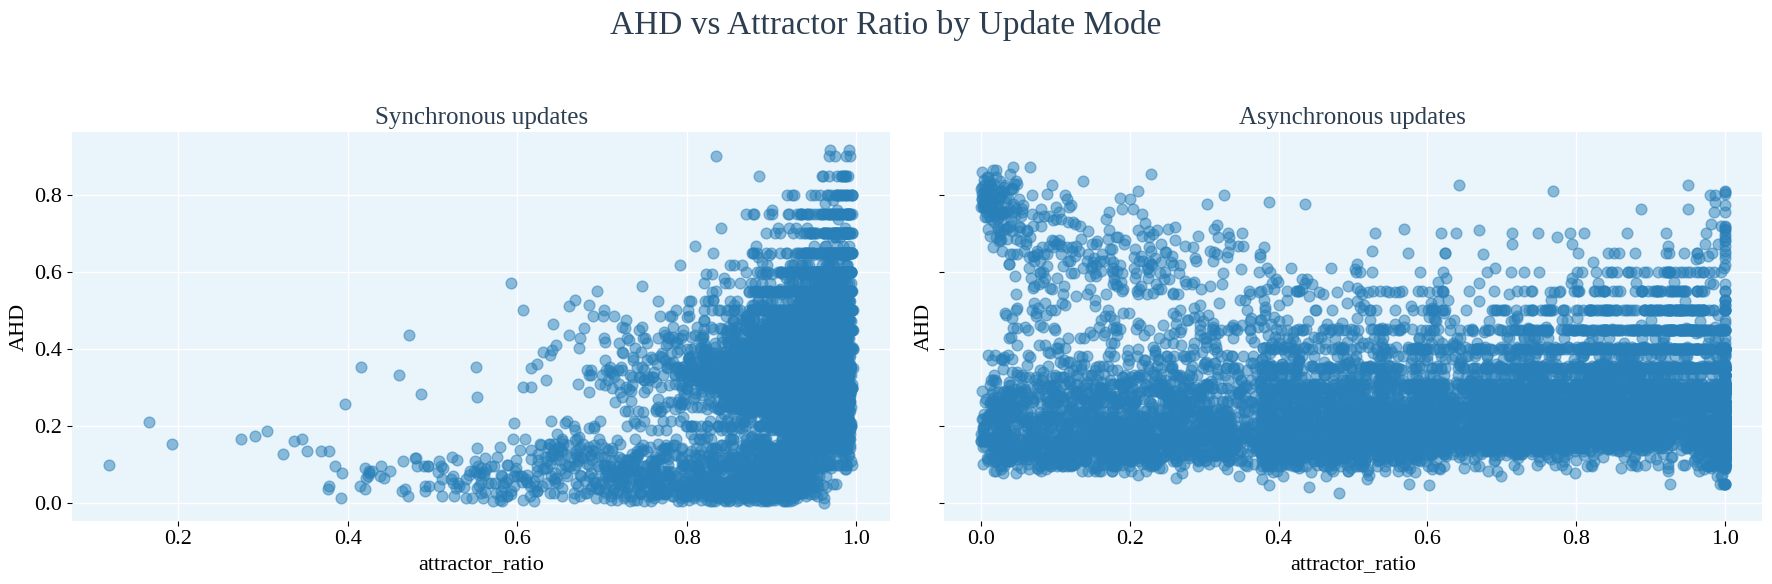

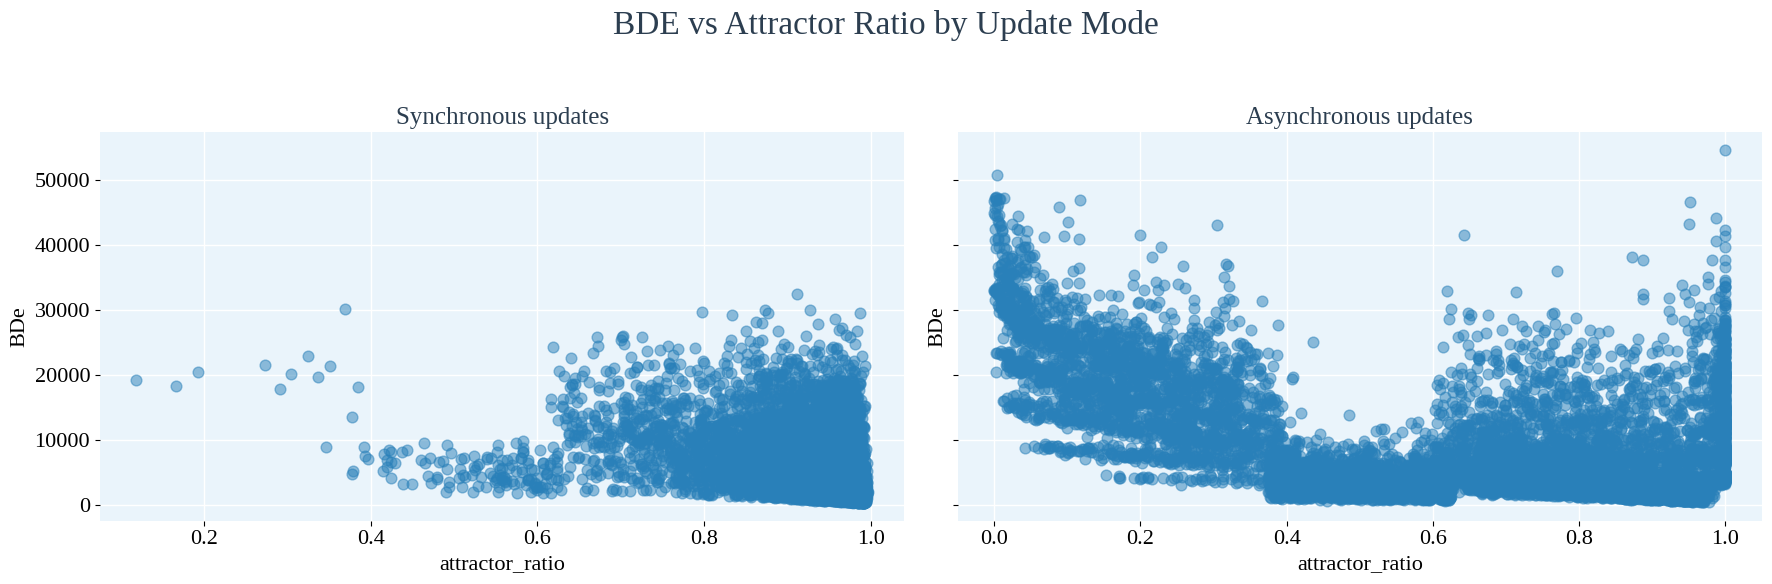

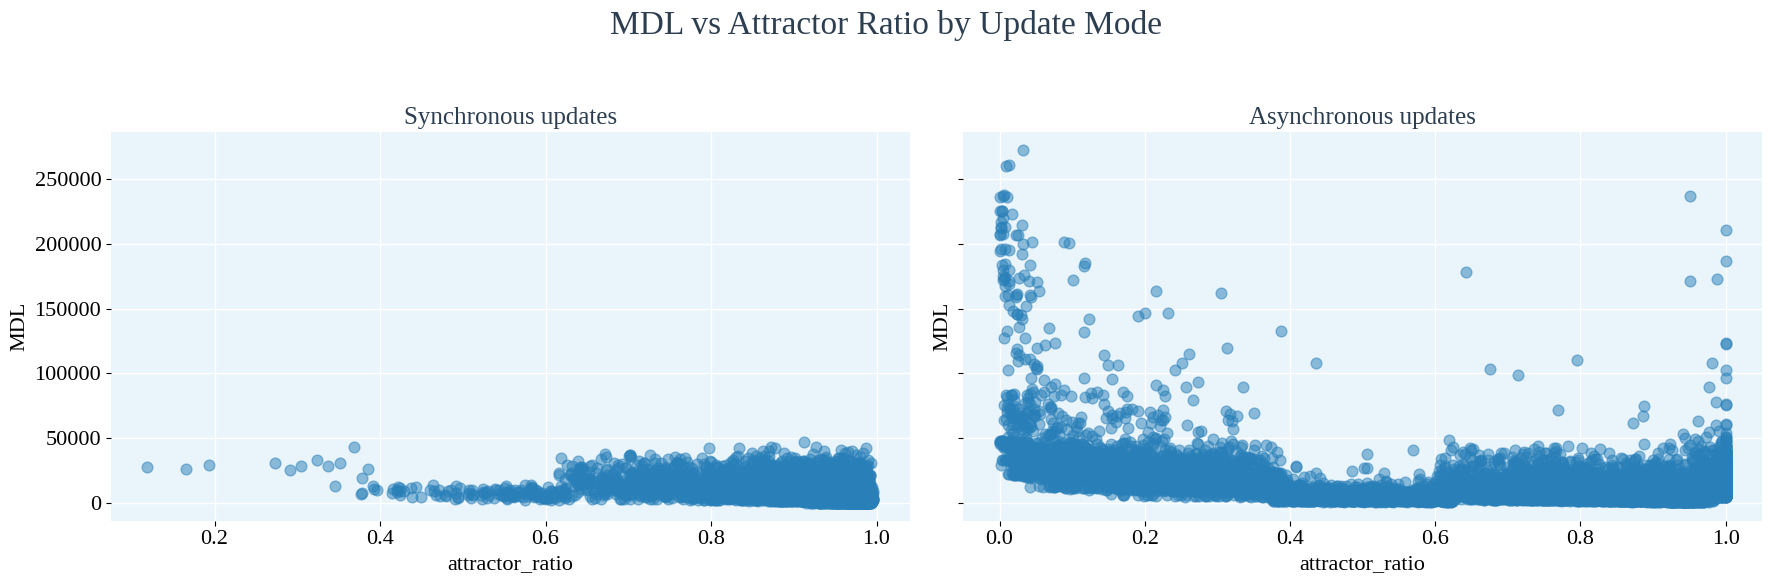

In [6]:
category_colors = ['#C0392B', '#2980B9', '#27AE60', '#F4D03F', '#8E44AD']

plot_scatter_subplots(df1, x='attractor_ratio', y='SHD', title='SHD vs Attractor Ratio by Update Mode')
plot_scatter_subplots(df1, x='attractor_ratio', y='AHD', title='AHD vs Attractor Ratio by Update Mode')
plot_scatter_subplots(df1, x='attractor_ratio', y='BDe', title='BDE vs Attractor Ratio by Update Mode')
plot_scatter_subplots(df1, x='attractor_ratio', y='MDL', title='MDL vs Attractor Ratio by Update Mode')

##### Results:

* In the **SHD plots**, under **synchronous updates**, most points are clustered at **high attractor ratios (>0.6)**, with SHD ranging broadly from **0 to 80**, reflecting the substantial structural error associated with attractor-dominated datasets. In contrast, **asynchronous updates** show attractor ratios spanning the full range, but SHD is generally much lower for low attractor ratio trajectories, increasing gradually up to **~40**, confirming that asynchronous dynamics produce more informative trajectories.
* For **AHD**, synchronous updates again concentrate at **attractor ratios >0.6**, with AHD ranging between **0.1–0.8**, whereas asynchronous updates cover the full attractor range but exhibit a dense cluster near **0–0.5**, indicating overall lower adjacency errors compared to synchronous dynamics.
* For **BDe**, synchronous updates concentrate mostly at **attractor ratios >0.6, with BDe ranging between 0.0-2500**. In asynchronous updates, however, a downward trend in BDe can be observed for the atraktor_ratio range of 0.0-0.4. After that, most of the values ​​accumulate close to zero.
* For **MDE**, in synchronous updates attractor ratio were >0.4 and values of MDL were ranges between 0-50000, for asynchronous attractor ratio were spanning the full range and MDL were mostly ranging between 0.0-100000.

Together, these scatter plots visually confirm our earlier findings: **high attractor ratios are associated with greater reconstruction errors**, and the **update mode strongly shapes the distribution of errors**, with asynchronous updates producing generally more accurate reconstructions. These visualizations provide a bridge to investigating **which factors influence attractor prevalence**, a key driver of reconstruction difficulty.

**This observation motivates the next step of our study: since attractor ratio is a key driver of reconstruction error, we now investigate which network- and data-generating factors determine the prevalence of attractor states in Boolean network trajectories.**

##### 1. Relation Between Trajectory Length and Entering Attractors

**Objective.**
To characterize how trajectory length is related to the probability of entering attractors as a function of network size and dynamics.

**Experimental design.**

- The target attractor proportion is **not controlled**; trajectories evolve naturally.
- Trajectory lengths are varied in increments proportional to network size:
    - from 10 steps to 50 by 10
- Networks are grouped by size (from 4 to 16 nodes, in steps of two).
- The number of parents per node is randomly chosen from set of $\{1,2,3\}$ to avoid conditioning results on a fixed connectivity pattern.

**Measured quantities.**

- Probability of reaching an attractor as a function of trajectory length.
- How different groups (below TODO - inner link) differ in in this probability.

**Rationale.**
Attractor entry is an emergent property of the dynamics. Controlling it directly is undesirable, as it would introduce selection bias. This experiment instead characterizes the **natural scaling behavior** of Boolean network dynamics.


(<Figure size 1300x500 with 1 Axes>,
 <Axes: title={'center': 'Asynchronous: Attractor Ratio vs Trajectory Length\nGrouped by num_nodes'}, xlabel='trajectory_length', ylabel='attractor_ratio'>)

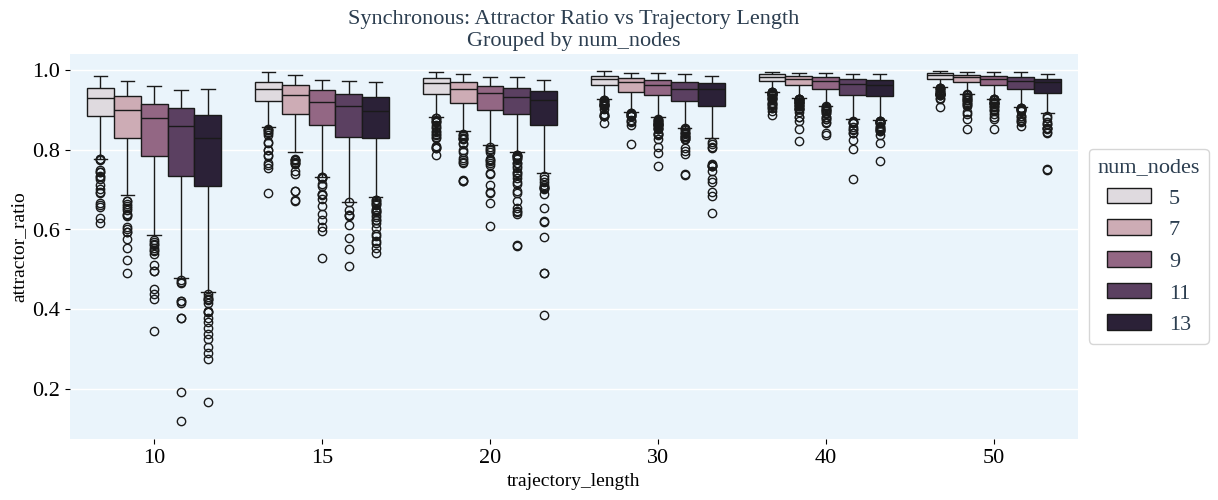

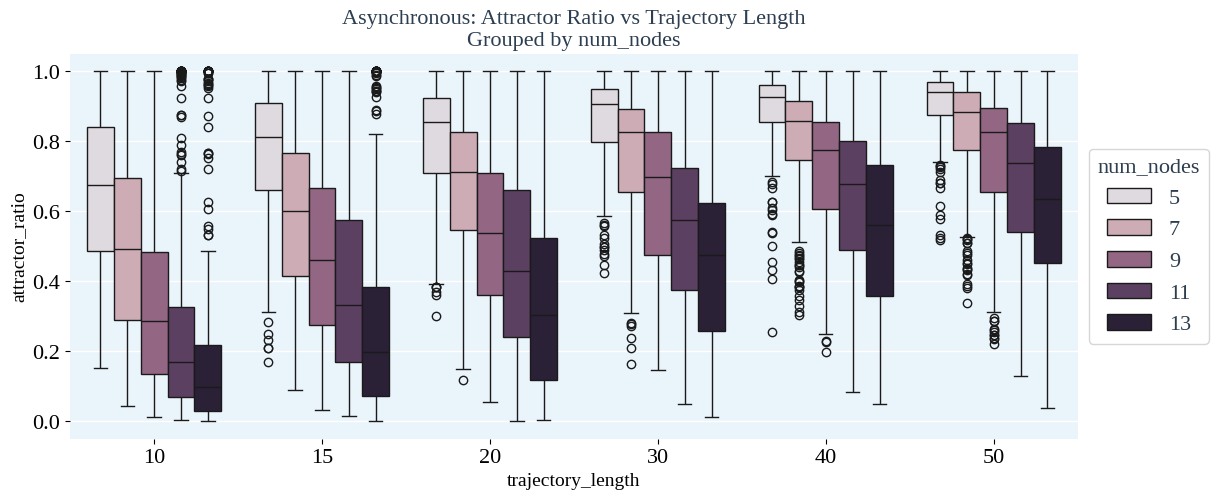

In [7]:
df_synchronous = df1[df1["update_mode"]=="synchronous"]
df_asynchronous = df1[df1["update_mode"]=="asynchronous"]

# Boxplot grouped by num_nodes synchronous
plot_boxplot(df_synchronous, x='trajectory_length', y='attractor_ratio', hue='num_nodes',
             title='Synchronous: Attractor Ratio vs Trajectory Length\nGrouped by num_nodes')
# Boxplot grouped by num_nodes synchronous
plot_boxplot(df_asynchronous, x='trajectory_length', y='attractor_ratio', hue='num_nodes',
             title='Asynchronous: Attractor Ratio vs Trajectory Length\nGrouped by num_nodes')

#### Results

To further explore the factors influencing attractor prevalence, we generated boxplots of **attractor ratio versus trajectory length**, grouped by **network size (num_nodes)**, separately for **synchronous** and **asynchronous** updates.

* **Synchronous updates:** attractor ratios are generally higher across all trajectory lengths, consistent with the expected behavior of synchronous Boolean networks, where simultaneous node updates tend to drive the system more quickly into attractor states.
* **Asynchronous updates:** attractor ratios are lower overall and more widely distributed, reflecting the increased variability and longer transient dynamics inherent to asynchronous update schemes.

Across both update modes, we observe consistent trends:

1. **Trajectory length effect:** attractor ratio tends to increase with longer trajectories.
2. **Network size effect:** attractor ratio tends to decrease as the number of nodes increases.

These observations visually confirm the patterns suggested by our regression and scatter plot analyses, providing an intuitive view of how **update mode, trajectory length, and network size jointly shape attractor prevalence** in simulated Boolean networks.

#### Scaling Law Analysis: Normalizing Trajectory Length by Network Size

To systematically compare how trajectory length and network size jointly influence convergence, we introduced a **scaling metric**: the **scale_ratio**, defined as `trajectory_length / num_nodes`. This metric normalizes the simulation time by the network’s complexity, allowing us to identify a unified scaling behavior across different system sizes.

In [8]:
df_summary = (
    df
    .groupby(["trajectory_length", "num_nodes"])
    .agg(
        median_ar=("attractor_ratio", "median"),
        q25_ar=("attractor_ratio", lambda x: x.quantile(0.25)),
        mean_ar=("attractor_ratio", "mean"),
        std_ar=("attractor_ratio", "std"),
        n=("attractor_ratio", "size")
    )
    .reset_index()
)

df_summary["scale_ratio"] = (
    df_summary["trajectory_length"] / df_summary["num_nodes"]
)

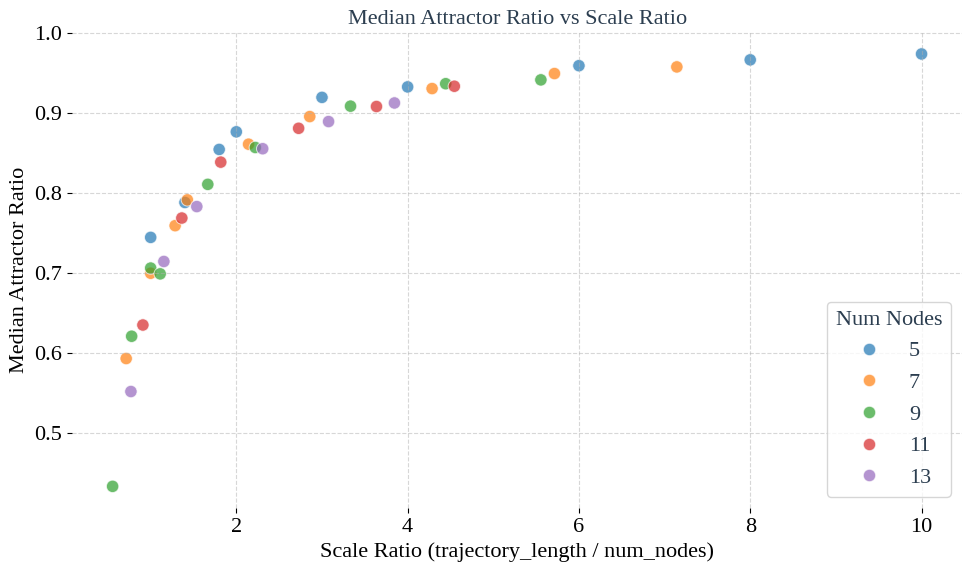

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df_summary,
    x="scale_ratio",
    y="median_ar",
    hue="num_nodes",
    palette="tab10",
    s=80,       
    alpha=0.7   
)

plt.xlabel("Scale Ratio (trajectory_length / num_nodes)")
plt.ylabel("Median Attractor Ratio")
plt.title("Median Attractor Ratio vs Scale Ratio", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.5)


ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)

plt.legend(title="Num Nodes")
plt.tight_layout()
plt.show()


##### **Results:**
We could notice that **the lower scale ratio, the lower median attractor ratio**. This means that there is a significant relationship between the **structure of the Boolean network** on the basis of which we create our trajectory.

### Experiment 2

In [ ]:
# Adjust data
## Add results from part 1
### Create new df for reproducibility 
df_series = df.copy()
### dropping values < threshold
df_series['scale'] = df_series["trajectory_length"] / df_series["num_nodes"]
df_series = df_series[df_series['scale'] < 1.5]
### dropping sets that are meaningles
df_series = df_series[
    (df_series["trajectory_length"] / df_series["sampling_frequency"]) > 1
]
## Add ACF and ESS information 
df_series = analyze_datasets_from_index(df_series, 'condition_id_name', DATASET_1_PATH, 1)

# merge 
df_series

#### Part 0: Sample Size Adequacy and Statistical Validity 

Before applying any statistical tests, we verify that the number of available observations remains sufficient after filtering the data. In particular, we removed:

* configurations with scale ratio below 1.5,
* cases without effective subsampling (single-sample trajectories).

After this filtering step, we assess whether the remaining sample sizes are still representative.

The resulting sample counts are as follows:

* **sampling frequency × number of nodes**: at least 240 observations per group, and up to 480 in larger configurations,
* **scoring function × number of nodes**: between 540 and 1140 observations, depending on the condition.

These sample sizes are quite large, and still have all repetitions for every experiment.

In [11]:
# sampling frequency vs num_nodes
table = pd.pivot_table(
    df_series,
    index='sampling_frequency',
    columns='num_nodes',
    aggfunc='size',
    fill_value=0
)
table

num_nodes            5    7    9    11   13
sampling_frequency                         
1                   240  480  480  240  240
2                   240  480  480  240  240
3                   240  480  480  240  240
4                   240  480  480  240  240
5                   120  360  360  240  240

In [12]:
# score function vs num_nodes
table = pd.pivot_table(
    df_series,
    index='score_function',
    columns='num_nodes',
    aggfunc='size',
    fill_value=0
)
table

num_nodes        5     7     9    11   13
score_function                           
BDE             540  1140  1140  600  600
MDL             540  1140  1140  600  600

#### Part 1: ESS and ACF vs Sampling Frequency 

##### Methodology 

We analyze the **mean lag-1 autocorrelation**, denoted `mean_lag1_acf`, which measures dependence between consecutive sampled time points. Lag 1 is chosen because it captures correlation between two adjacent time points.  

ESS is computed to quantify the amount of effectively independent information contained in the sampled trajectories. Higher ESS should bring more information to model training and improve reconstruction quality. 

***

##### Results: Lag-1 Autocorrelation (ACF)

For **synchronous update**, the distribution of `mean_lag1_acf` is centered close to zero across all sampling frequencies and network sizes. No systematic trend with respect to sampling frequency is observed. This behavior is expected, as synchronous dynamics define a deterministic mapping between states; subsampling does not substantially alter short-range temporal dependence.

For **asynchronous update**, we observe:

* a clear decrease in lag-1 autocorrelation when increasing sampling frequency from 1 to 3,
* a weaker but still noticeable change between frequencies 1 and 4,
* a potential degradation or saturation between frequencies 4 and 5.

These observations suggest that subsampling reduces short-range dependence in asynchronous trajectories up to a point, beyond which additional subsampling start to increase ACF. The non-monotonic behavior at higher sampling frequencies requires further statistical testing to assess significance.

***

##### Results: Effective Sample Size (ESS) 

For **synchronous update**, ESS increases clearly with sampling frequency across all network sizes. This indicates that subsampling effectively reduces redundancy in deterministic dynamics. 

For **asynchronous update**, the pattern is less clear:

* ESS values are substantially lower than in the synchronous case,
* increases in sampling frequency do not translate into uniform gains in ESS,
* ESS appears to depend jointly on sampling frequency and network size.

This suggests that stochastic update dynamics introduce long-range temporal correlations that are not fully mitigated by simple subsampling. As a result, sampling frequency alone is insufficient to ensure an increase in ESS in asynchronous trajectories.

##### Conclusion
For both **synchronous** and **asynchronous** update there is no clear relation between ESS and ACF. In next parts we will need to examine them independently. 

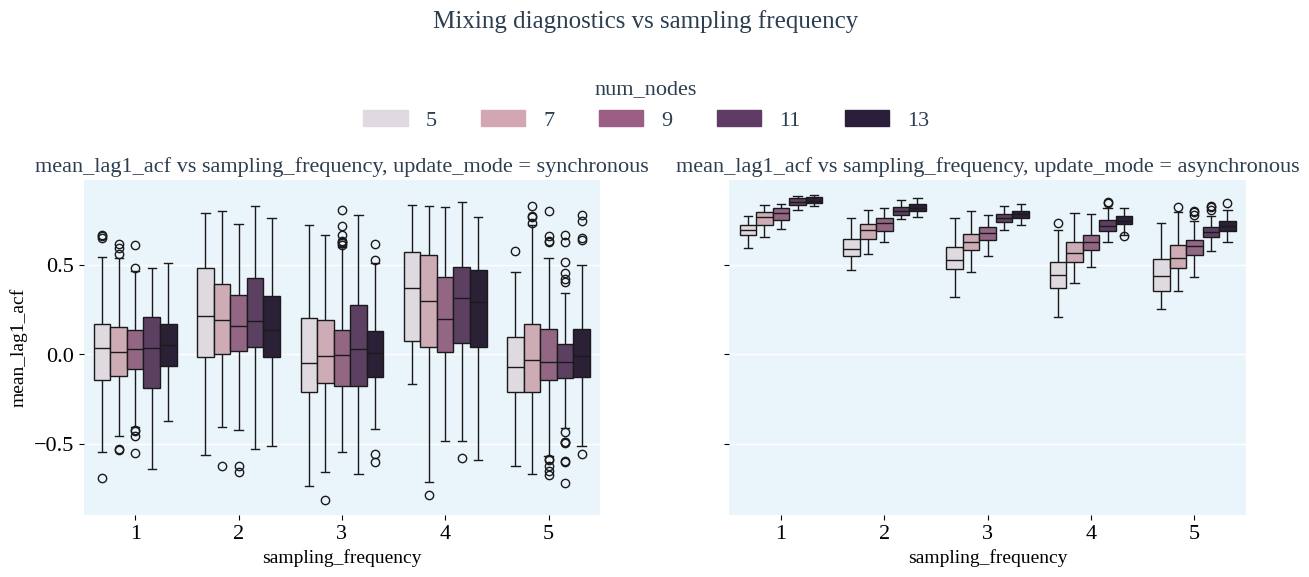

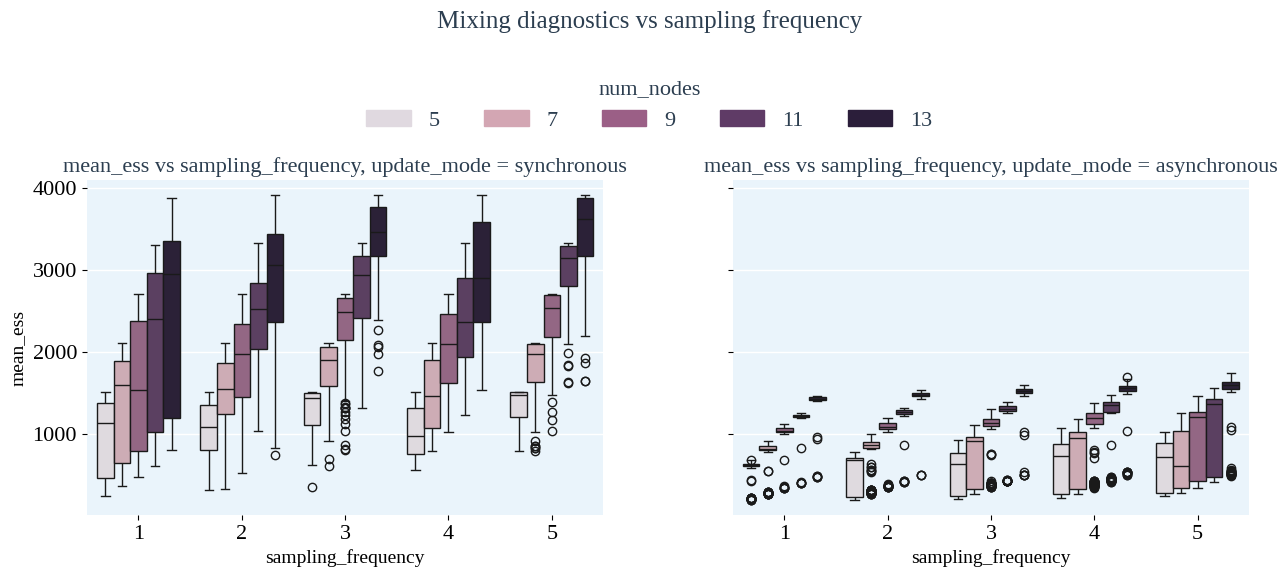

In [13]:

plot_grouped_boxplots(
    df=df_series,
    group_col=None,                       # ← kluczowe
    x_col="sampling_frequency",
    y_cols=["mean_lag1_acf", "mean_ess"],
    hue_col="num_nodes",
    facet_col="update_mode",              # ← porównanie sync vs async
    facet_levels=["synchronous", "asynchronous"],
    main_title="Mixing diagnostics vs sampling frequency",
)




#### Part 2: Reconstruction quality vs sampling frequency

##### Methodology

In this analysis, we study the relationship between **sampling frequency** and **model reconstruction quality**, measured using the structural accuracy metrics **AHD** and **SID**.

The objective is to determine how changes in sampling frequency affect the quality of inferred network structures.

***

##### Analysis: Synchronous update 

For the **synchronous update mode**, a clear pattern is observed in both reconstruction metrics.

As shown in:

* **AHD vs sampling frequency** plots (top row, synchronous panels),
* **SID vs sampling frequency** plots (middle upper row, synchronous panels),

the smallest values of both AHD and SID are obtained for **sampling frequency = 1**, across all network sizes and for both MDL and BDe scoring functions. Increasing the sampling frequency leads to a systematic degradation of reconstruction quality.

Given the consistency of this effect across metrics, scoring functions, and network sizes, no further statistical testing is required for the synchronous case.

##### Analysis: Asynchronous update

For the **asynchronous update mode**, the behavior is not as clear.

From the corresponding plots:

* **AHD vs sampling frequency** (middle lower row, asynchronous panels),
* **SID vs sampling frequency** (bottom row, asynchronous panels),

we observe that reconstruction quality generally improves when increasing sampling frequency from 1 to approximately 3. Beyond this point improvement becomes inconsistent across network sizes and score functions.

This lack of monotonicity indicates that, in the asynchronous case, the relationship between sampling frequency and reconstruction quality is mediated by additional factors, such as long-range temporal dependence and network size. Consequently, inferential statistical tests are required to assess the significance of these trends.

***


##### Conclusions

We find a clear relationship between **sampling frequency** and **model reconstruction quality**, but this relationship is different for synchronous and asynchronous case:

* For **synchronous dynamics**, the optimal choice is **sampling frequency = 1**, as any subsampling leads to a consistent loss of structural and causal accuracy.
* For **asynchronous dynamics**, reconstruction quality generally improves with subsampling up to a moderate frequency (around 3), but no single optimal value can be identified without further statistical testing.

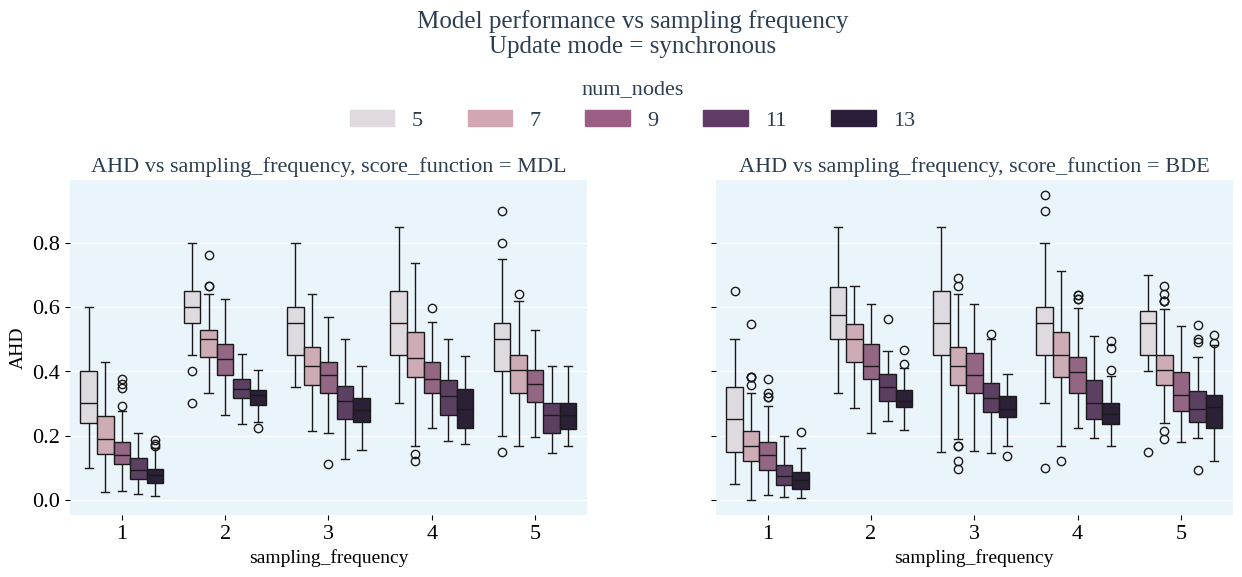

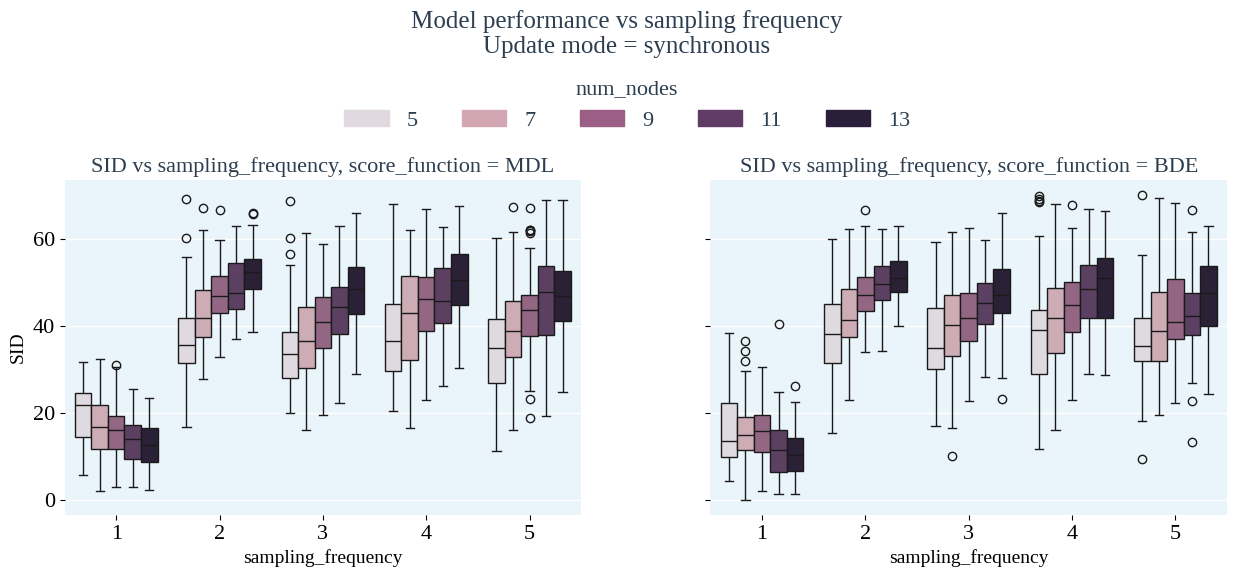

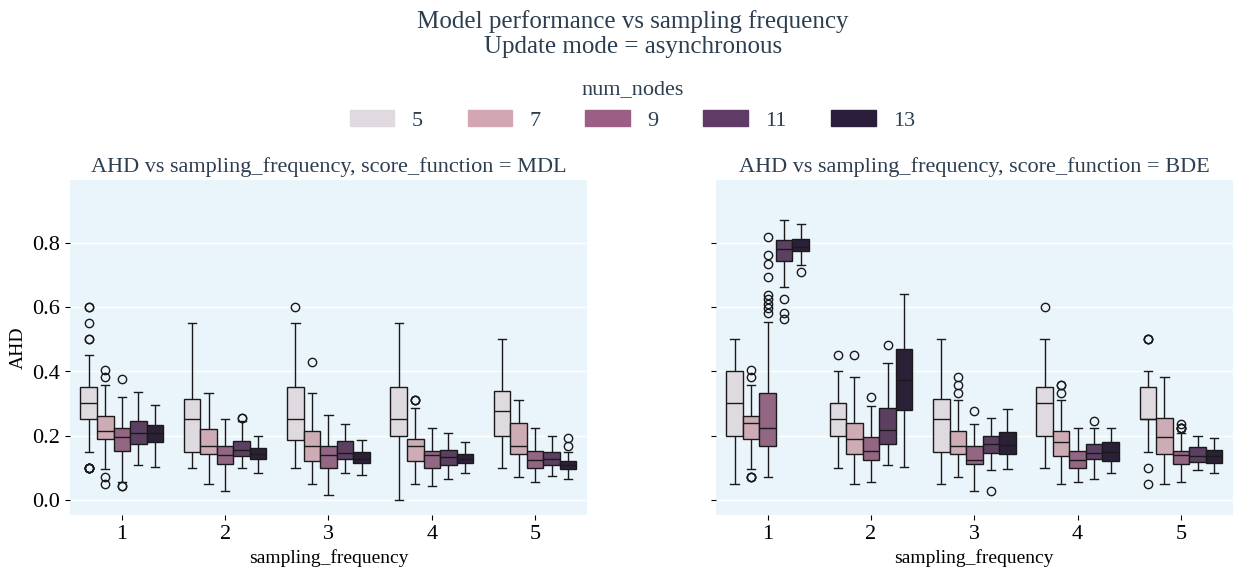

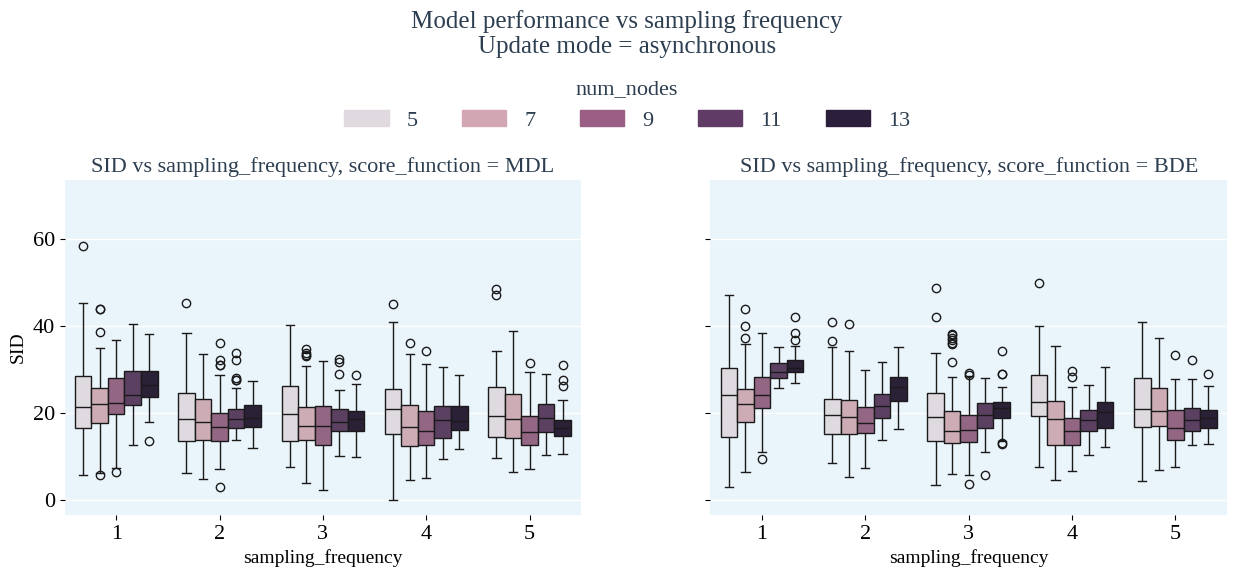

In [14]:
plot_grouped_boxplots(
    df=df_series,
    group_col="update_mode",
    x_col="sampling_frequency",
    y_cols=["AHD", "SID"],
    hue_col="num_nodes",
    facet_col="score_function",
    facet_levels=["MDL", "BDE"],
    main_title="Model performance vs sampling frequency",
    group_title_fmt="Update mode = {}"
)



#### Part 3 – Spearman Correlation Analysis

##### Methodology

The main objective of this analysis is to assess whether properties of a data: **ESS** and **lag-1 ACF**, are associated with **model reconstruction quality**, measured using AHD and SID.

we compute **Spearman rank correlations** between:

* ESS and reconstruction metrics,
* lag-1 ACF and reconstruction metrics,

separately for groups defined by:

* update mode,
* score function,
* number of nodes.
* sampling_frequency

After prior filtering, each group contains between **60 and 120 observations**, which is sufficient for stable estimation of Spearman correlations if $\rho \geq 0.4$ (see Bonett & Wright, 2000).  Correlations are presented as heatmaps, independently for each combination of `num_nodes` and `score_function` and `update_mode`.

This analysis is conducted separately for ESS and ACF, as results from part 1 indicate that these quantities are not interchangeable and may capture different aspects of temporal dependence.

***

##### Results: ESS

The results for ESS are summarized in the **ESS–AHD** and **ESS–SID** heatmaps.

For the **synchronous update mode** (top heatmaps), Spearman correlation coefficients are close to zero across all network sizes and both scoring functions. No consistent monotonic relationship between ESS and reconstruction quality is observed for either AHD or SID.

In contrast, for the **asynchronous update mode** (bottom heatmaps), a clear negative trend is visible:

* ESS exhibits moderate negative correlations with AHD and SID,
* correlations are stronger for larger networks, ($\geq 9$)
* several correlations (3/12) are statistically significant.

This may suggest that, in asynchronous systems, higher effective sample size is associated with improved reconstruction quality, whereas in synchronous systems ESS does not appear to be a limiting factor. 

***


##### Results: Lag-1 Autocorrelation (ACF)

The analysis of lag-1 ACF reveals a complementary pattern.

For **synchronous update**, correlations between ACF and reconstruction metrics remain weak and inconsistent across all configurations, confirming that short-range autocorrelation does not meaningfully affect reconstruction quality in this regime.

For **asynchronous update**, we observe statistically significant correlations in selected configurations with larger BN (9, 11, 13):

* a significant correlation between ACF and **AHD** for the **MDL** score,
* a significant correlation between ACF and **SID** for the **BDe** score.

These effects are visible in the asynchronous ACF heatmaps and suggest that 
dependence on neighborhood samples influence negatively reconstruction quality.

***


##### Conclusions

We conclude that:

* There is **no meaningful monotonic relationship** between ESS or ACF and reconstruction quality in synchronous systems.
* In asynchronous systems, **higher ESS is may be associated with improved reconstruction quality**.
* In asynchronous systems, **Lag-1 ACF influences negatively reconstruction quality**

##### Reference

Bonett, D. G., & Wright, T. A. (2000). Sample size requirements for estimating Pearson, Kendall and Spearman correlations. Psychometrika, 65, 23–28.

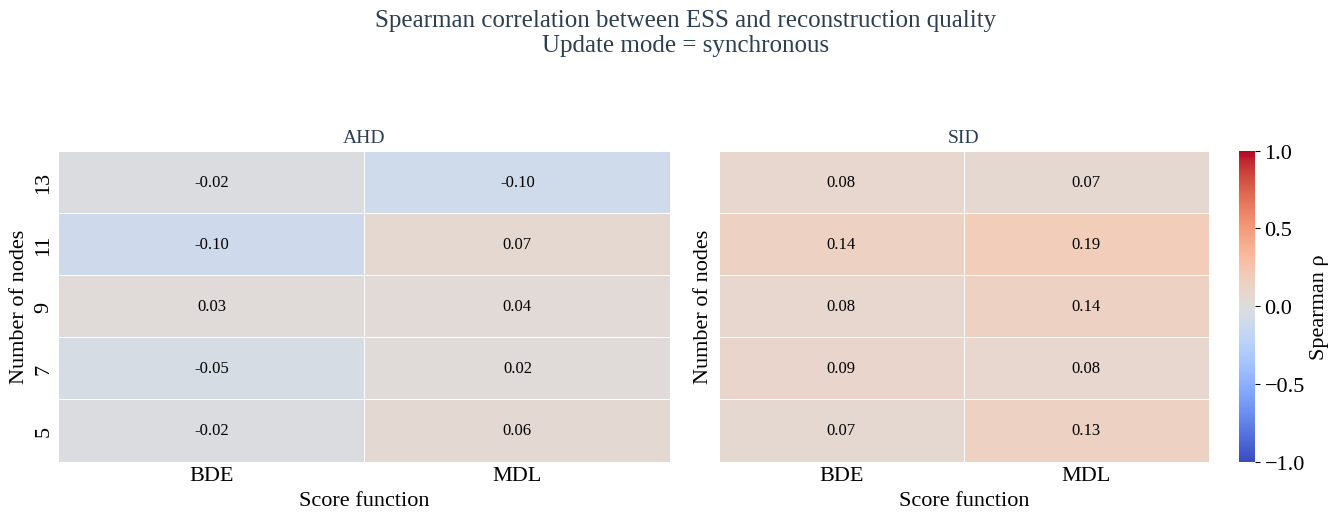

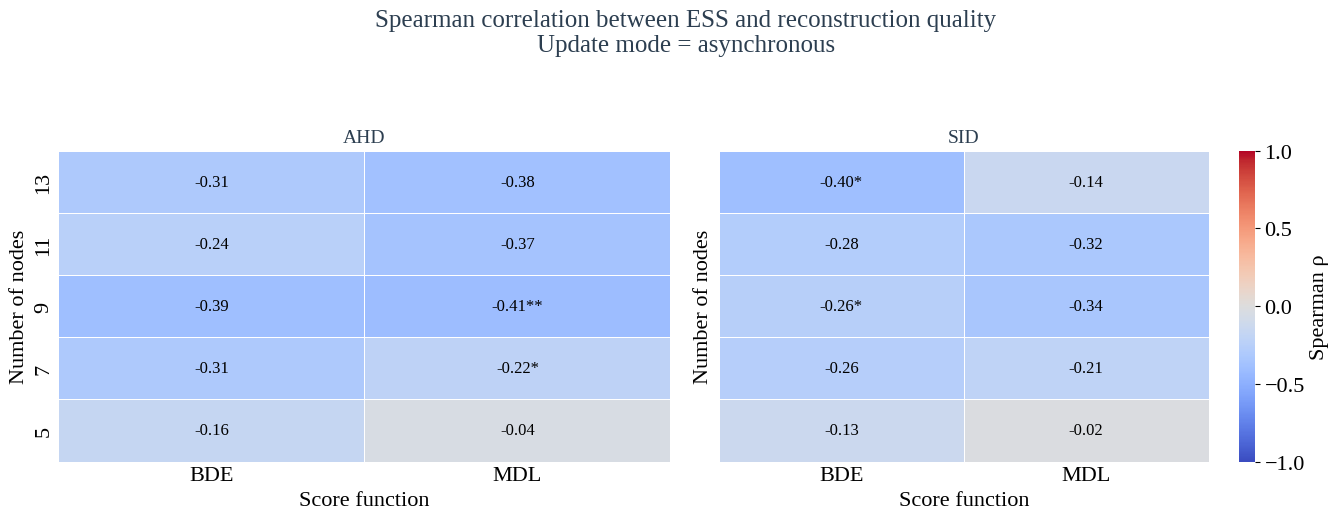

<Figure size 640x480 with 0 Axes>

In [15]:
group_cols = ["update_mode", "score_function", "num_nodes", "sampling_frequency"]

df_spearman = compute_spearman_table(
    df_series,
    metrics=["AHD", "SID"],
    group_cols = group_cols,
    ess_col= "mean_ess"
)



for update_mode in ["synchronous", "asynchronous"]:

    fig, axes = plt.subplots(
        1, 2,
        figsize=(14, 5),
        sharey=True
    )

    plot_spearman_heatmap(
        df_spearman,
        metric="AHD",
        update_mode=update_mode,
        num_nodes_order=sorted(df_series["num_nodes"].unique(), reverse=True),
        ax=axes[0],
        cbar=False
    )

    plot_spearman_heatmap(
        df_spearman,
        metric="SID",
        update_mode=update_mode,
        num_nodes_order=sorted(df_series["num_nodes"].unique(), reverse=True),
        ax=axes[1],
        cbar=True
    )

    fig.suptitle(
        "Spearman correlation between ESS and reconstruction quality\n"
        f"Update mode = {update_mode}",
        fontsize=18,
        y=1.05
    )

    plt.tight_layout()
    plt.show()

plt.tight_layout()
plt.show()



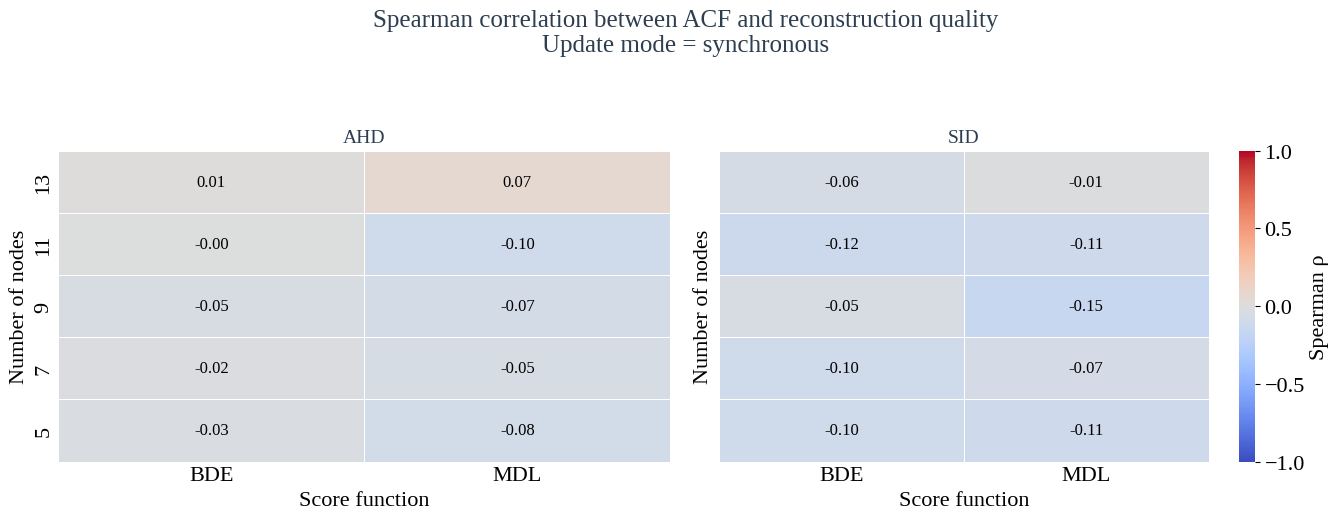

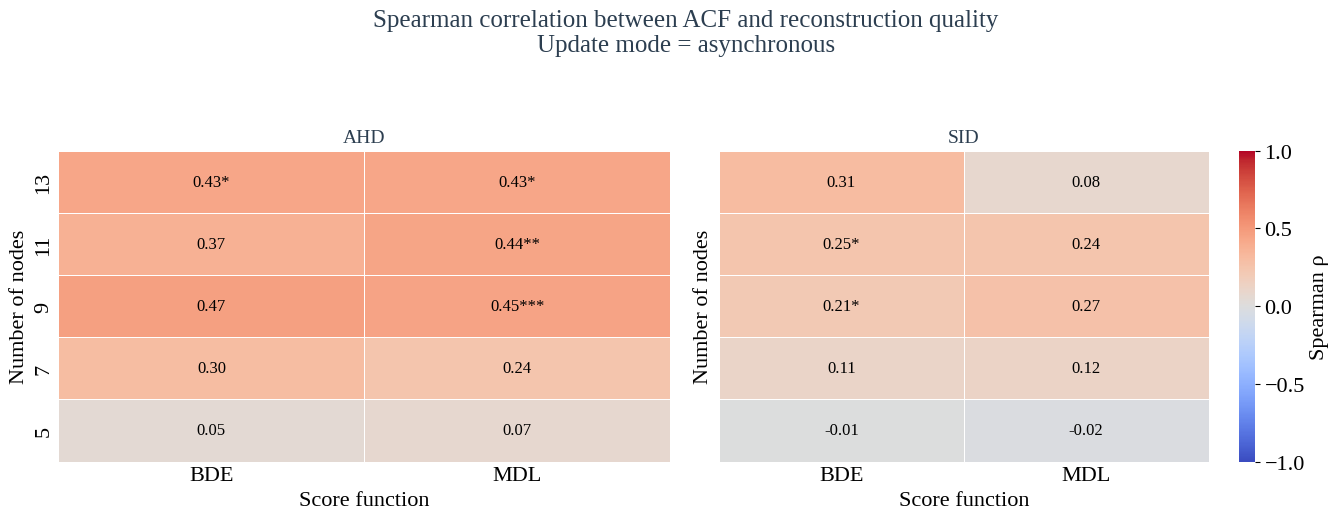

<Figure size 640x480 with 0 Axes>

In [16]:
group_cols = ["update_mode", "score_function", "num_nodes", "sampling_frequency"]

df_spearman = compute_spearman_table(
    df_series,
    metrics=["AHD", "SID"],
    group_cols = group_cols,
    ess_col= "mean_lag1_acf"
)


counts = (
    df_series
    .groupby(group_cols)
    .size()
    .reset_index(name="n_rows")
)
counts 

for update_mode in ["synchronous", "asynchronous"]:

    fig, axes = plt.subplots(
        1, 2,
        figsize=(14, 5),
        sharey=True
    )

    plot_spearman_heatmap(
        df_spearman,
        metric="AHD",
        update_mode=update_mode,
        num_nodes_order=sorted(df_series["num_nodes"].unique(), reverse=True),
        ax=axes[0],
        cbar=False
    )

    plot_spearman_heatmap(
        df_spearman,
        metric="SID",
        update_mode=update_mode,
        num_nodes_order=sorted(df_series["num_nodes"].unique(), reverse=True),
        ax=axes[1],
        cbar=True
    )

    fig.suptitle(
        "Spearman correlation between ACF and reconstruction quality\n"
        f"Update mode = {update_mode}",
        fontsize=18,
        y=1.05
    )

    plt.tight_layout()
    plt.show()

plt.tight_layout()
plt.show()



In [17]:
counts = (
    df_series
    .groupby(group_cols)
    .size()
    .reset_index(name="n_rows")
)
counts 

update_mode score_function  num_nodes  sampling_frequency  n_rows
0   asynchronous            BDE          5                   1      60
1   asynchronous            BDE          5                   2      60
2   asynchronous            BDE          5                   3      60
3   asynchronous            BDE          5                   4      60
4   asynchronous            BDE          5                   5      30
..           ...            ...        ...                 ...     ...
95   synchronous            MDL         13                   1      60
96   synchronous            MDL         13                   2      60
97   synchronous            MDL         13                   3      60
98   synchronous            MDL         13                   4      60
99   synchronous            MDL         13                   5      60

[100 rows x 5 columns]



#### Part 4. Does increasing sampling frequency significantly improve median reconstruction quality?

##### Methodology

The objective of this analysis is to assess whether **increasing the sampling frequency (sampling factor)** leads to **statistically significant changes in the median values of reconstruction quality metrics** for AHD and SID.

The analysis is conducted **exclusively for the asynchronous update mode**, as in the synchronous setting the descriptive results clearly indicate that the best reconstruction quality is achieved for **sampling factor equal to 1**, making further statistical comparisons unnecessary.

To isolate the effect of sampling frequency, all statistical tests are performed **within homogeneous experimental groups**, defined by the following variables:

* update mode,
* score function,
* number of nodes.

For each group, **paired comparisons** are performed between consecutive sampling factors (1→2, 2→3, 3→4, 4→5). The analysis considers two reconstruction quality metrics:

* AHD,
* SID,

and two score functions:

* BDe,
* MDL.

Statistical significance of median differences is assessed using the **single (greater) Wilcoxon signed-rank test**.

Depending on the experimental condition, the number of paired observations equals **900, 1800, or 3600**, which allows the applied tests to be considered as having **high statistical power**.

The results are summarized in a heatmap that presents:

* the median difference between consecutive sampling factors,
* statistical significance levels for each comparison.

***

##### Analysis

For **BDe**, a **statistically significant improvement in reconstruction quality is observed for the transition from sampling factor 2 to 3**, indicating a meaningful change in the ranking of graph structures induced by this cost function. No further gains are observed for higher sampling factors.

In contrast, when using **MDL**, statistically significant differences are observed only for the  transition from **sampling factor 1 to 2**. 

Importantly, these effects reflect changes in the **values of the cost functions used to rank candidate graph structures**, rather than direct improvements in the reconstruction metrics themselves. The observed differences may arise from BDe and MDL different construction, and usage of prior information from BDe.


***



#### Recommended configuration

Based on the obtained results, the following recommendations can be formulated:

* **synchronous**:
  the optimal sampling factor is **3** (part 2)

* **BDe (asynchronous)**:
  the optimal sampling factor is **3**, we show that changes in direction (1-2-3) significantly increase reconstruction quality (AHD, SID). 

* **MDL (asynchronous)**:
  the optimal sampling factor is **2**, we show that changes in direction (1-2) significantly increase reconstruction quality (AHD, SID). 

Higher sampling factors does not bring any differences, to reconstruction quality, it may only reduce them. 

In [18]:
group_cols = ["update_mode", "score_function", "num_nodes"]
df_wilcoxon = compute_wilcoxon_table(
    df_series,
    metrics=["AHD", "SID"],
    group_cols=group_cols,
    transitions=[(1,2), (2,3), (3,4), (4,5)], #TODO - tutaj wstawic kolejnośc z jaką chcesz sprawdzać (20, 40) ...
    sf_col='sampling_frequency' #TODO - tutaj wstawić tą kolumne co masz stałą normalizacji 
)

df_wilcoxon['n_pairs']
df_wilcoxon



metric  sf_from  sf_to transition  n_pairs  wilcoxon_stat       p_value  \
0      AHD        1      2        1→2     1800       816147.0  1.849133e-26   
1      AHD        2      3        2→3     1800       666709.0  1.449905e-03   
2      AHD        3      4        3→4     1800       413684.0  1.000000e+00   
3      AHD        4      5        4→5      900       192721.0  3.888873e-09   
4      SID        1      2        1→2     1770       968494.0  8.380032e-20   
..     ...      ...    ...        ...      ...            ...           ...   
155    AHD        4      5        4→5     1800       982430.0  5.386245e-24   
156    SID        1      2        1→2     1800            0.0  1.000000e+00   
157    SID        2      3        2→3     1800      1137545.0  4.606971e-50   
158    SID        3      4        3→4     1800       624218.0  1.000000e+00   
159    SID        4      5        4→5     1800      1088559.0  9.296540e-37   

     median_diff   update_mode score_function  num_nodes  
0      -0.050000  asynchronous            BDE          5  
1       0.000000  asynchronous            BDE          5  
2       0.050000  asynchronous            BDE          5  
3      -0.050000  asynchronous            BDE          5  
4      -2.995849  asynchronous            BDE          5  
..           ...           ...            ...        ...  
155    -0.019231   synchronous            MDL         13  
156    39.171777   synchronous            MDL         13  
157    -3.632954   synchronous            MDL         13  
158     2.430778   synchronous            MDL         13  
159    -4.118898   synchronous            MDL         13  

[160 rows x 11 columns]

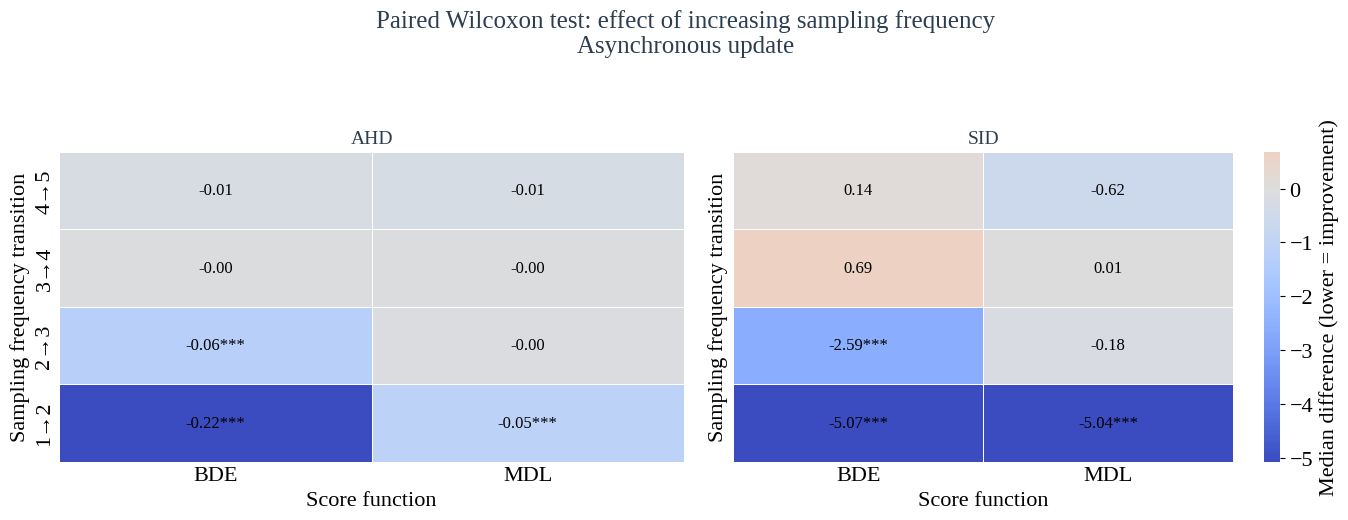

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

plot_wilcoxon_heatmap(
    df_wilcoxon,
    metric="AHD",
    update_mode="asynchronous",
    transitions_order=sorted(df_wilcoxon['transition'].unique(), reverse=True),
    ax=axes[0],
    cbar=False
)

plot_wilcoxon_heatmap(
    df_wilcoxon,
    metric="SID",
    update_mode="asynchronous",
    transitions_order=sorted(df_wilcoxon['transition'].unique(), reverse=True),
    ax=axes[1],
    cbar=True
)

fig.suptitle(
    "Paired Wilcoxon test: effect of increasing sampling frequency\n"
    "Asynchronous update",
    fontsize=18,
    y=1.05
)

plt.tight_layout()
plt.show()



### Experiment 3

#### Part 1: Distribution of metrics as function of normalization value $k$.

##### Methodology 

We want to analyze if there is some relation between normalization value $k$ and reconstruction quality. 

We draw barplots of metrics (SHD, AHD, SID) as function of $k$. With respect to experimental groups. 


##### Analysis

**Synchronous networks**

In synchronous network we can observe that:
* SHD have tendency to raise for higher $k$ values,
* AHD and SID obtain the smallest IQR when $k$ value is between $40, 60$

It can be caused because of overfitting the model. SHD rising value is expected because this measure is not normalized to the size of network, although AHD and SID metrics are getting worse at the same time so model is probably making more FP edges. 


**Asynchronous network**

In asynchronous network we can observe that:
* SHD value is not changing visibly, 
* AHD and SID values are getting lower with each $k$ value. 

The model probably need more samples to get fit. Asynchronous models have more edges than synchronous this can cause difference in optimal $k$ value.

**Relation between $k$ value and boolean network size**

We can see that amount of probes is not only dependent on size of network. Despite usage of normalization we see differences between distributions due to network size. We will

**Differences between score functions**

**Conclusions**
- We can not assume that size of network is irrelevant (?):
    - Despite normalization, size of network still influence reconstruction quality. We 
- We see differences in optimal $k$ value fro synchronous and asynchronous networks. Probably due to complexity differences between them. 
- We suspect that optimal values of $k$ is:
    - around 40-60 for synchronous networks,
    - around 120 for asynchronous networks.
To make any significant conclusions, we need to perform statistical tests, because differences are to blurry



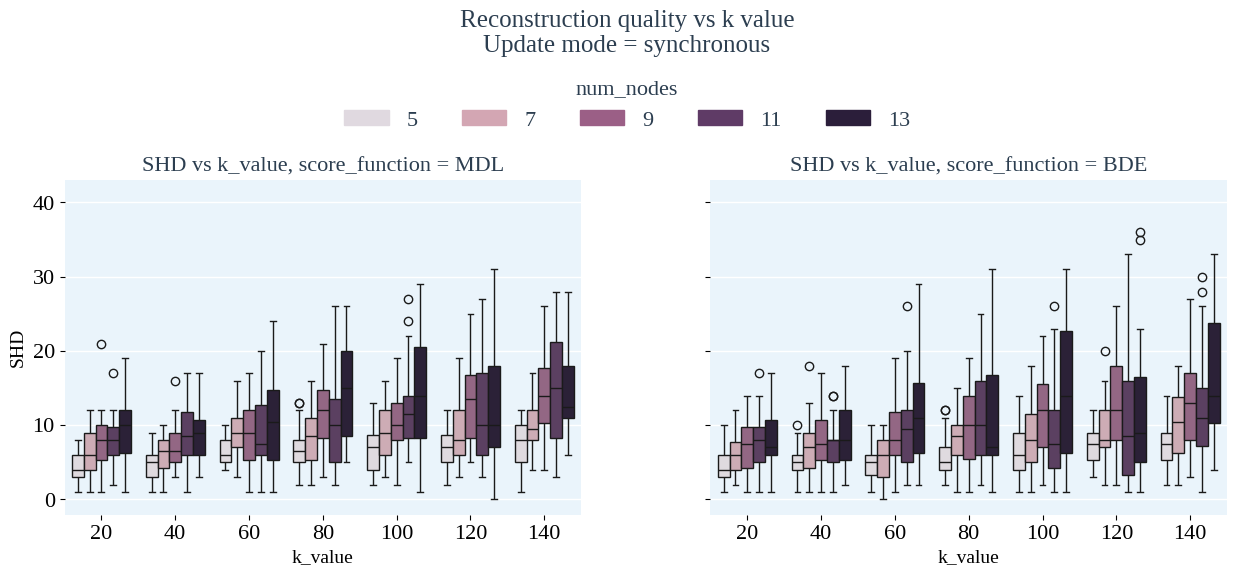

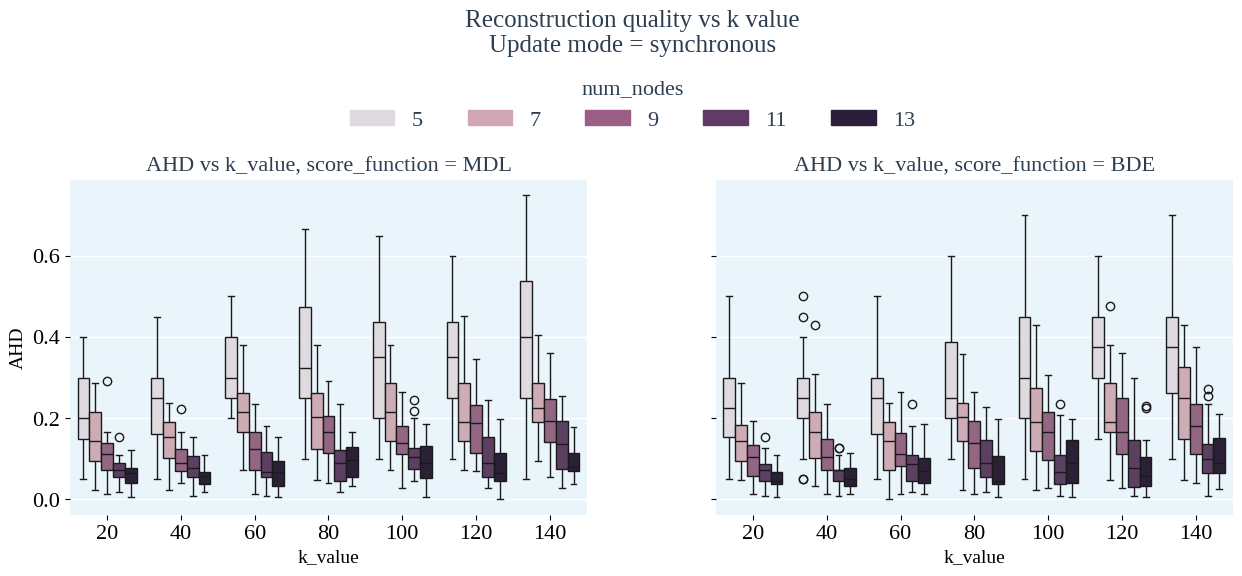

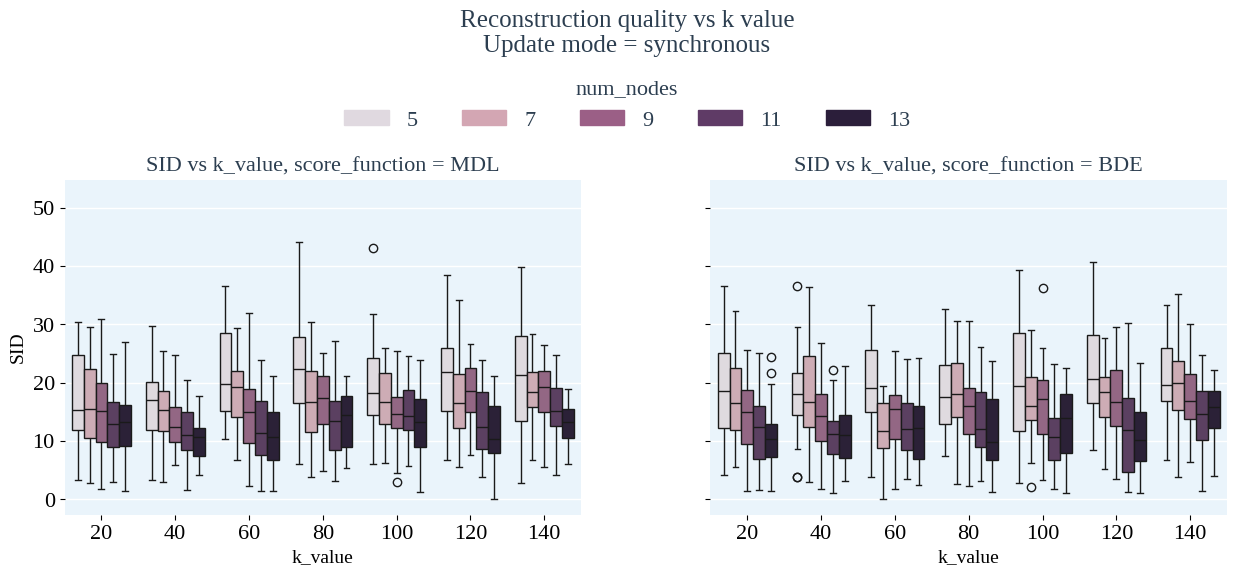

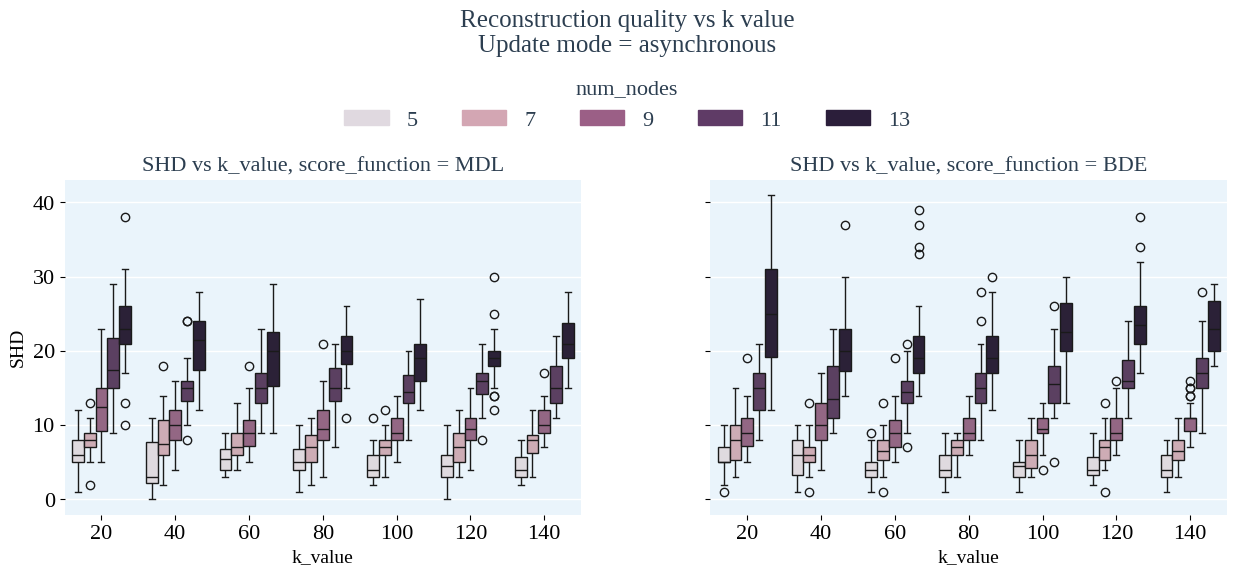

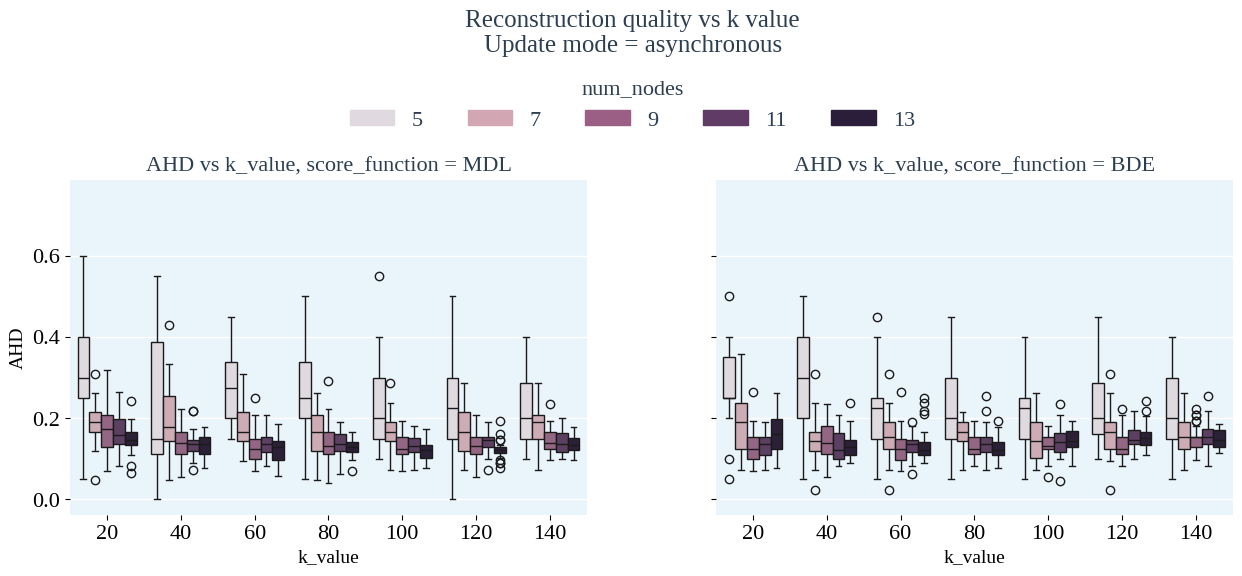

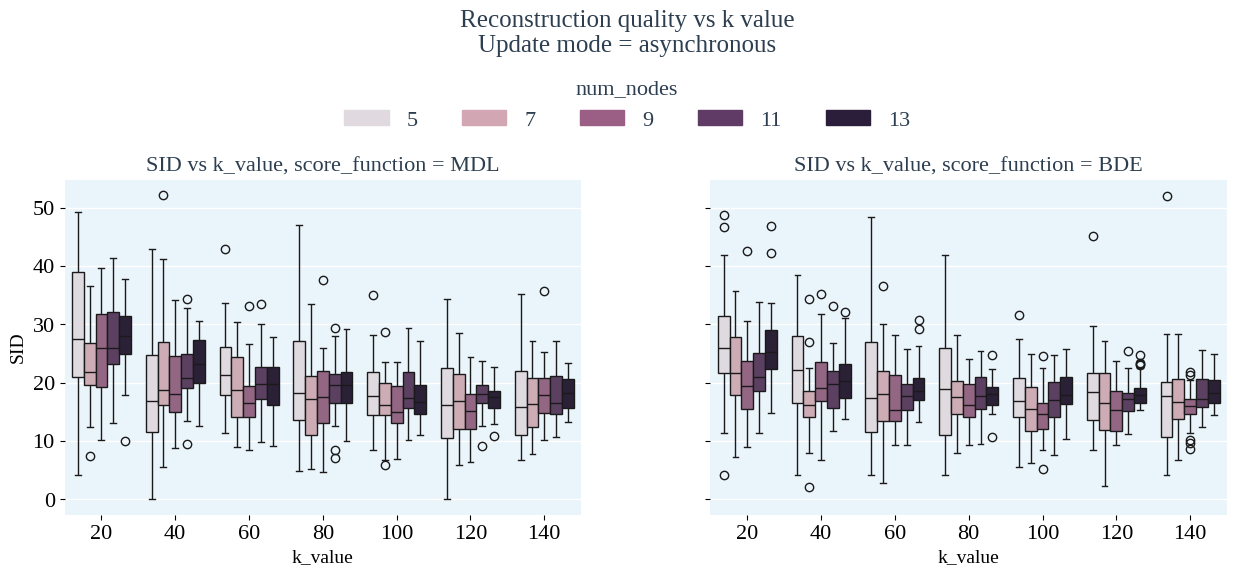

In [20]:
plot_grouped_boxplots(
    df=pd.concat([dfs, dfa], axis=0),
    group_col="update_mode",                       # ← kluczowe
    x_col="k_value",
    y_cols=["SHD", "AHD", "SID"],
    hue_col="num_nodes",
    facet_col="score_function",              # ← porównanie sync vs async
    facet_levels=["MDL", "BDE"], # 
    main_title="Reconstruction quality vs k value",
    group_title_fmt="Update mode = {}"
)

#### Part 2: Statistical analysis - optimal $k$ value

##### Methodology

We want to examine whether there exists significant relation between $k$ value and reconstruction quality. We use for it Wilcoxon tests (median difference). Group were specified by:
- update mode
- score function
- size of network 

##### Analysis

**Synchronous**
In synchronous network we can observe that:
- SHD median in most cases is significantly worse than in previous amount if iterations. We can see that error is scaling with size of network ($N=11$, $N=13$), this is due to SHD is not normalized metric.
- AHD median is significantly worse oraz neutral.
- SID median have two different pattern:
    - networks of size $N=5, 7$ have mixed results, we can not see and pattern
    - networks of size $N = 9, 11, 13$, have significant better results with $k=40$, 


**Asynchronous** 
In asynchronous network we can observe that:
- SHD median have smaller value in more complicated networks which is counter intuitive, because SHD measure is not normalized
- AHD median mostly is without any significant change that changes metric value. In case of network with size $N=5$, is significantly better
- SID median is increasing significantly. Case ($N=5$ MDL $40\rightarrow60$) can be significantly negative because of higher decrease in case ($N=5$, MDL, $20\rightarrow60$)


**Impact of network size**
We do not observe clear impact of network size between test. In my opinion all results are shift by base margin error value that boolean networks of certain size can obtain.

**Impact of score function**
We do not observe any clear relation between tests results and score function used for training.

##### Recommended configuration
Based on above reasoning we suggest following $k$ value:

| Network type / condition | k   |
|--------------------------|-----|
| Synchronous, N ≤ 5       | 20  |
| Synchronous, N > 5       | 40  |
| Asynchronous             | 100 |


In [21]:
df_wilcoxon_s = compute_wilcoxon_table(
    dfs,
    metrics=["AHD", "SHD", "SID"],
    transitions=[(i*20, (i+1)*20) for i in range(1, 7)],
    group_cols=('update_mode', 'score_function', 'num_nodes'),
    sf_col='k_value',
    alternative='two-sided'
)
df_wilcoxon_s

metric  sf_from  sf_to transition  n_pairs  wilcoxon_stat       p_value  \
0      AHD       20     40      20→40      900       129033.5  1.357409e-05   
1      AHD       40     60      40→60      900       143497.0  3.268240e-01   
2      AHD       60     80      60→80      900       118322.0  2.741310e-14   
3      AHD       80    100     80→100      900       150376.0  7.886647e-04   
4      AHD      100    120    100→120      900       126042.0  2.147257e-09   
..     ...      ...    ...        ...      ...            ...           ...   
175    SID       40     60      40→60      900       178858.0  2.639192e-03   
176    SID       60     80      60→80      900       119053.0  7.669799e-27   
177    SID       80    100     80→100      900       189696.0  9.487393e-02   
178    SID      100    120    100→120      900       145133.0  1.548726e-13   
179    SID      120    140    120→140      900       151207.0  3.995100e-11   

     median_diff  update_mode score_function  num_nodes  
0       0.025000  synchronous            BDE          5  
1       0.000000  synchronous            BDE          5  
2       0.050000  synchronous            BDE          5  
3       0.025000  synchronous            BDE          5  
4       0.050000  synchronous            BDE          5  
..           ...          ...            ...        ...  
175     0.676836  synchronous            MDL         13  
176     3.233301  synchronous            MDL         13  
177    -0.427172  synchronous            MDL         13  
178    -1.930044  synchronous            MDL         13  
179     1.695263  synchronous            MDL         13  

[180 rows x 11 columns]

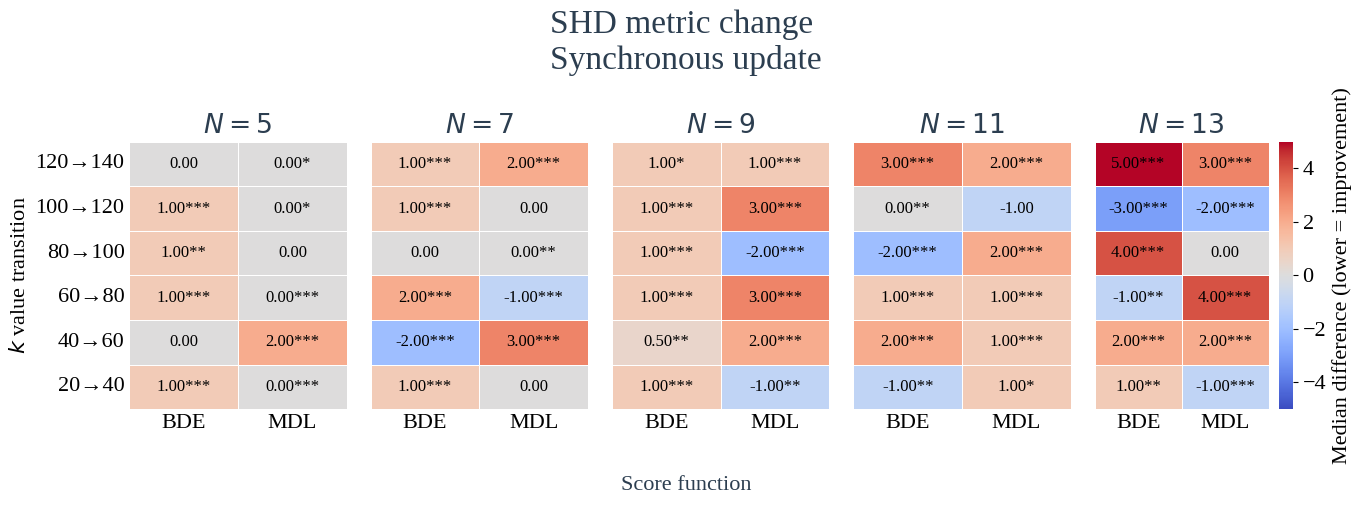

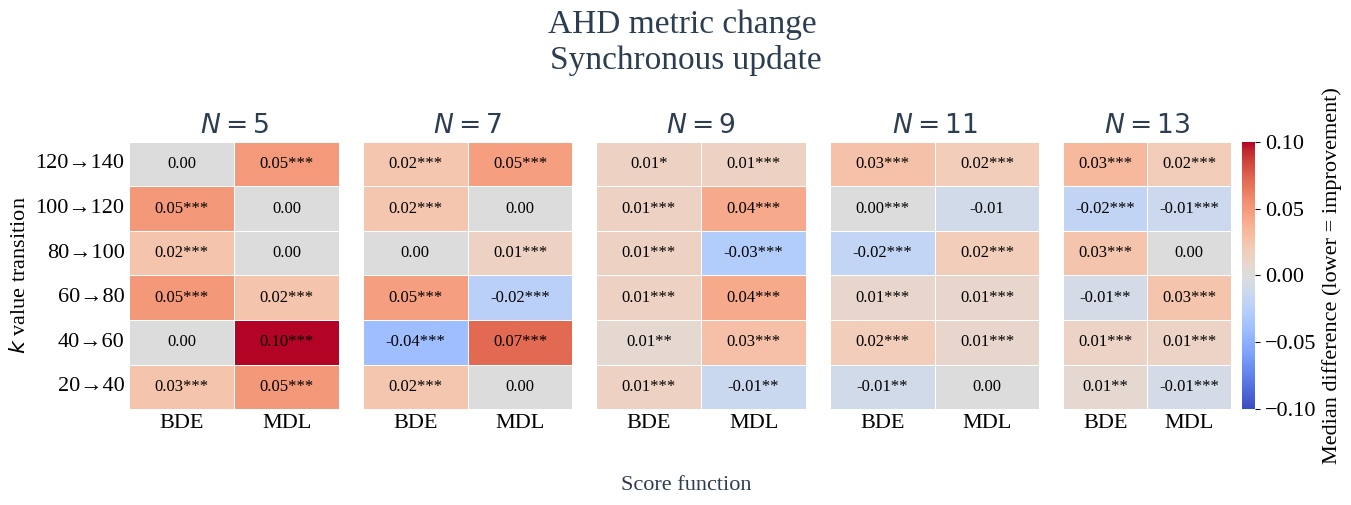

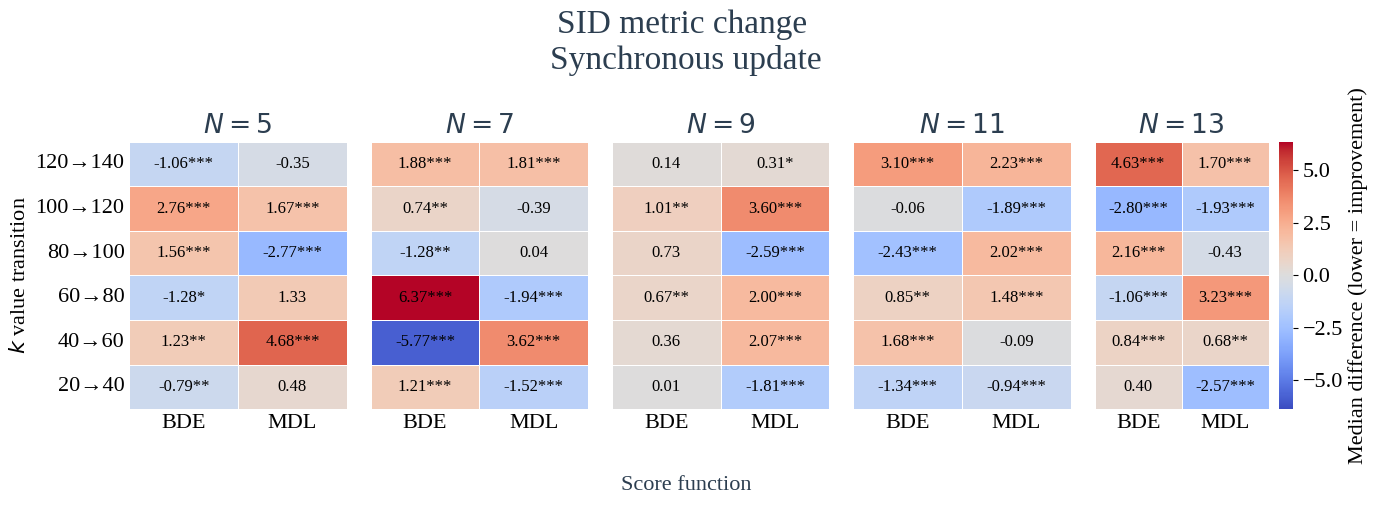

In [22]:
# parameters
metrics= ["SHD", "AHD", "SID"]

# values preparation
## Creating transition order (special sign) 
transitions_order = sorted(df_wilcoxon_s['transition'].unique(), 
       key = lambda x: int(x.split('→')[0]),
       reverse=True)
## get list of nodes
num_nodes_list = df_wilcoxon_s['num_nodes'].unique()

# Metric adjustment loop
for metric in metrics:
    ## common scale
    df_m = df_wilcoxon_s[df_wilcoxon_s["metric"] == metric]
    abs_max = np.nanmax(np.abs(df_m["median_diff"]))
    vmin, vmax = -abs_max, abs_max
    fig, axes = plt.subplots(1, 5, figsize=(14, 5), sharey=True)
    ## Single heatmap loop
    for i, num_nodes in enumerate(num_nodes_list):
        ### filt node value 
        filt = df_wilcoxon_s['num_nodes'] == num_nodes
        ### add num_nodes plot 
        plot_wilcoxon_heatmap(
            #### values
            df_wilcoxon_s[filt],
            metric=metric,
            update_mode="synchronous",
            transitions_order=transitions_order,
            #### plot settings
            ax=axes[i],
            cbar=False if i < len(num_nodes_list) - 1 else True,
            vmin=vmin,
            vmax=vmax,
            ylabel = '$k$ value transition',
        )

        ### set labels
        #### set subplot label
        axes[i].set_title(f"$N = {num_nodes}$")
        ### remove y labels on inner subplots
        if i != 0:
            axes[i].set_ylabel("")  # usuwa "Sampling frequency" z pozostałych
        #### remove singular  
        axes[i].set_xlabel("")     # usuwa "Score function"

    # figure settings
    ## labels
    fig.suptitle(f'{metric} metric change \nSynchronous update', fontsize=24)
    fig.supxlabel("Score function", fontsize=16)    

    # plot
    plt.tight_layout()
    plt.show()


In [23]:
df_wilcoxon_a = compute_wilcoxon_table(
    dfa,
    metrics=["AHD", "SHD", "SID"],
    transitions=[(i*20, (i+1)*20) for i in range(1, 7)],
    group_cols=('update_mode', 'score_function', 'num_nodes'),
    sf_col='k_value',
    alternative='two-sided'
)
df_wilcoxon_a

metric  sf_from  sf_to transition  n_pairs  wilcoxon_stat       p_value  \
0      AHD       20     40      20→40      900       153720.0  5.266167e-01   
1      AHD       40     60      40→60      900        88064.0  9.664483e-30   
2      AHD       60     80      60→80      900       149643.5  5.451409e-01   
3      AHD       80    100     80→100      900       127773.0  2.144319e-03   
4      AHD      100    120    100→120      900       106984.0  1.064129e-08   
..     ...      ...    ...        ...      ...            ...           ...   
175    SID       40     60      40→60      900        90484.0  6.107409e-47   
176    SID       60     80      60→80      900       189130.0  8.137082e-02   
177    SID       80    100     80→100      900       131743.0  9.082072e-20   
178    SID      100    120    100→120      900       187630.5  8.614896e-02   
179    SID      120    140    120→140      900       150237.0  2.356261e-11   

     median_diff   update_mode score_function  num_nodes  
0       0.000000  asynchronous            BDE          5  
1      -0.050000  asynchronous            BDE          5  
2       0.000000  asynchronous            BDE          5  
3       0.000000  asynchronous            BDE          5  
4       0.000000  asynchronous            BDE          5  
..           ...           ...            ...        ...  
175    -3.904238  asynchronous            MDL         13  
176     0.180156  asynchronous            MDL         13  
177    -2.045197  asynchronous            MDL         13  
178     0.010307  asynchronous            MDL         13  
179     0.992430  asynchronous            MDL         13  

[180 rows x 11 columns]

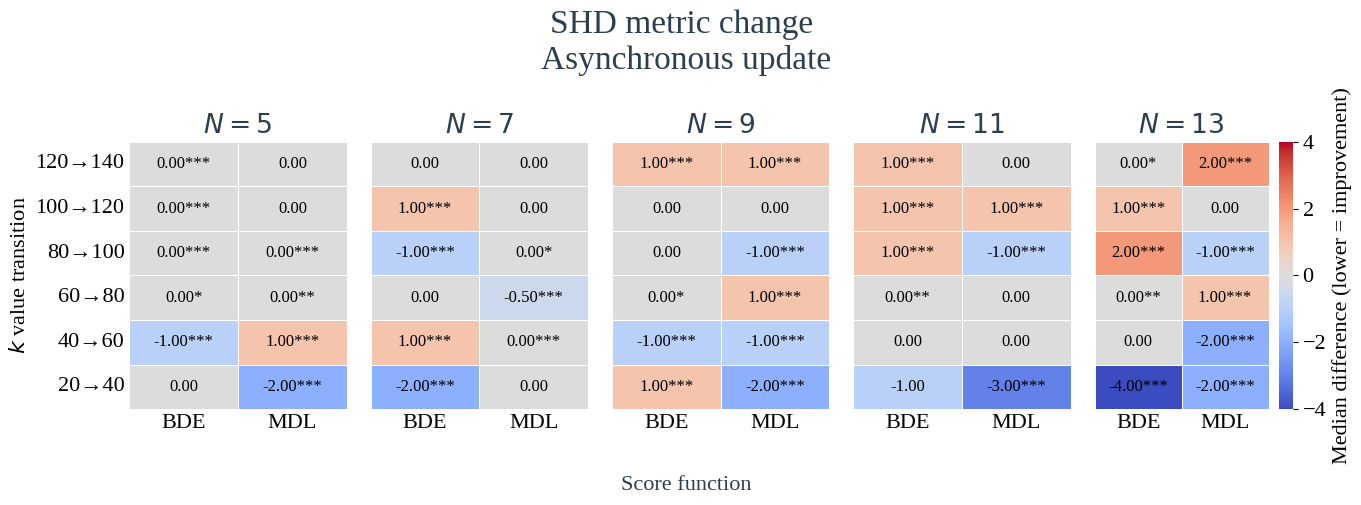

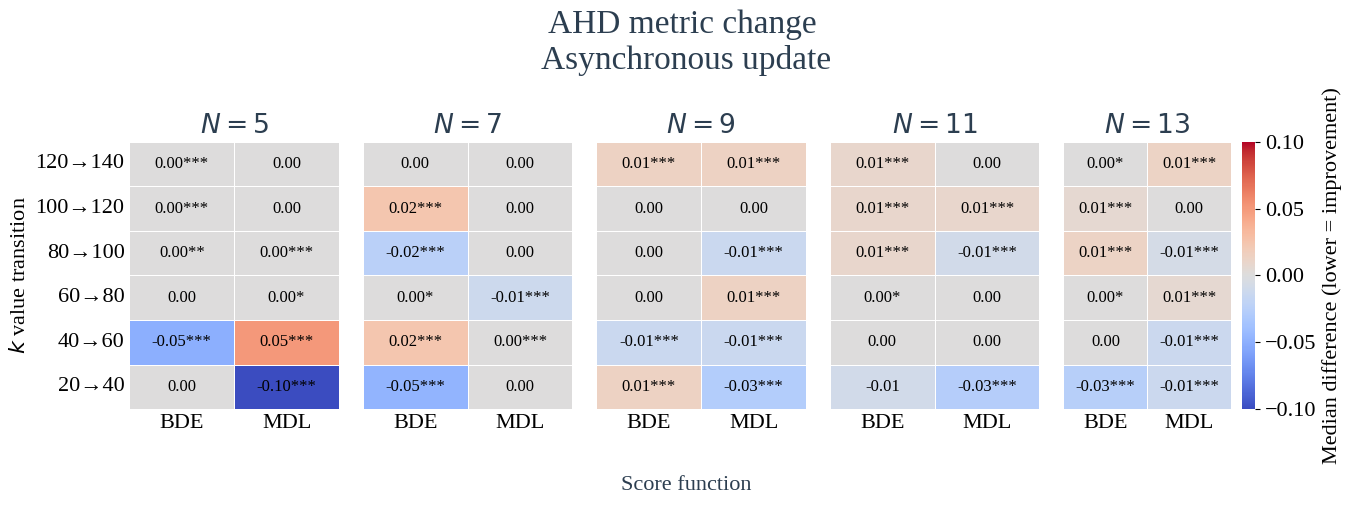

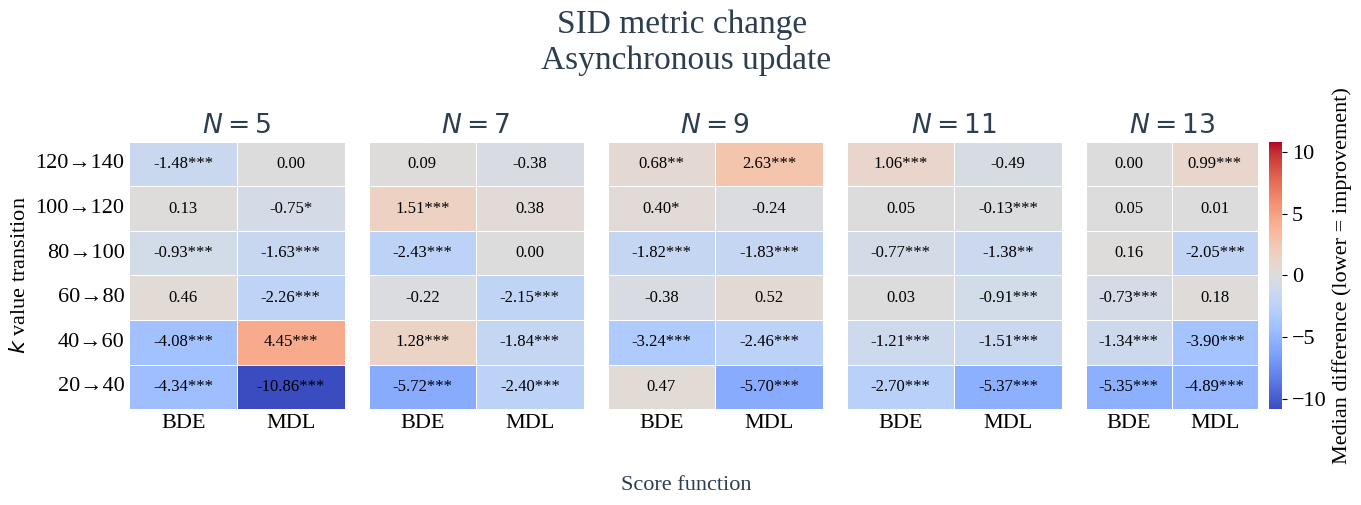

In [24]:
# parameters
metrics= ["SHD", "AHD", "SID"]

# values preparation
## Creating transition order (special sign) 
transitions_order = sorted(df_wilcoxon_a['transition'].unique(), 
       key = lambda x: int(x.split('→')[0]),
       reverse=True)
## get list of nodes
num_nodes_list = df_wilcoxon_a['num_nodes'].unique()

# Metric adjustment loop
for metric in metrics:
    ## common scale
    df_m = df_wilcoxon_a[df_wilcoxon_a["metric"] == metric]
    abs_max = np.nanmax(np.abs(df_m["median_diff"]))
    vmin, vmax = -abs_max, abs_max
    fig, axes = plt.subplots(1, 5, figsize=(14, 5), sharey=True)
    ## Single heatmap loop
    for i, num_nodes in enumerate(num_nodes_list):
        ### filt node value 
        filt = df_wilcoxon_a['num_nodes'] == num_nodes
        ### add num_nodes plot 
        plot_wilcoxon_heatmap(
            #### values
            df_wilcoxon_a[filt],
            metric=metric,
            update_mode="asynchronous",
            transitions_order=transitions_order,
            #### plot settings
            ax=axes[i],
            cbar=False if i < len(num_nodes_list) - 1 else True,
            vmin=vmin,
            vmax=vmax,
            ylabel = '$k$ value transition',
        )

        ### set labels
        #### set subplot label
        axes[i].set_title(f"$N = {num_nodes}$")
        ### remove y labels on inner subplots
        if i != 0:
            axes[i].set_ylabel("")  # usuwa "Sampling frequency" z pozostałych
        #### remove singular  
        axes[i].set_xlabel("")     # usuwa "Score function"

    # figure settings
    ## labels
    fig.suptitle(f'{metric} metric change \nAsynchronous update', fontsize=24)
    fig.supxlabel("Score function", fontsize=16)    

    # plot
    plt.tight_layout()
    plt.show()


### Experiment 4: Sensitivity to Scoring Function

#### Part 1:

**Objective:**
The aim of Experiment 4 is to evaluate how the choice of scoring function (MDL vs BDe) affects the quality of Boolean network reconstruction. We set here optimal parameters from previous experiments.

**Approach:**
Using datasets generated with fixed sampling and normalization parameters, we assess how the choice of scoring function (MDL vs BDe) influences the accuracy of Boolean network reconstruction across different network sizes and update modes. 

Reconstruction performance is evaluated in terms of AHD, SHD, and SID, allowing us to capture both topological accuracy and correctness of causal relationships. By systematically comparing these metrics across conditions, we aim to identify scoring function-specific tendencies and understand how the impact of the scoring criterion scales with network size and dynamical properties.

In [25]:
# add optimal flag
optimal_var = 'optimal_setting'
## results from experiment 3 (dataset 2)
### ASYNCHRONOUS: k = 100
dfa[optimal_var] = dfa['k_value'] == 100

### SYNCHRONOUS:
dfs[optimal_var] = (
    ((dfs['num_nodes'] <= 5) & (dfs['k_value'] == 20)) 
    |
    ((dfs['num_nodes'] > 5) & (dfs['k_value'] == 40))
)

## Dataset 1 
### ASYNCHRONOUS (limited by k value)
df[optimal_var] = (
    (df['update_mode']=='asynchronous') # only synchronous k=100
    & 
    (
        ((df['score_function']=='BDE') & (df['sampling_frequency']==3)) # BDE, sampling = 3
        |
        ((df['score_function']=='MDL') & (df['sampling_frequency']==2)) # MDL, sampling = 2
    )
)

## Select sets for experiment 4
dfs_exp4 = dfs[dfs[optimal_var]==True]
dfa_exp4 = dfa[dfa[optimal_var]==True]

## amount of data 
dfs_exp4.shape[0], dfa_exp4.shape[0]

(300, 300)

/home/maxi7524/repositories/SAD2_final_project/src/sad2_final_project/analysis/analysis.py:945: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxplot(
/home/maxi7524/repositories/SAD2_final_project/src/sad2_final_project/analysis/analysis.py:945: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxplot(
/home/maxi7524/repositories/SAD2_final_project/src/sad2_final_project/analysis/analysis.py:945: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxplot(


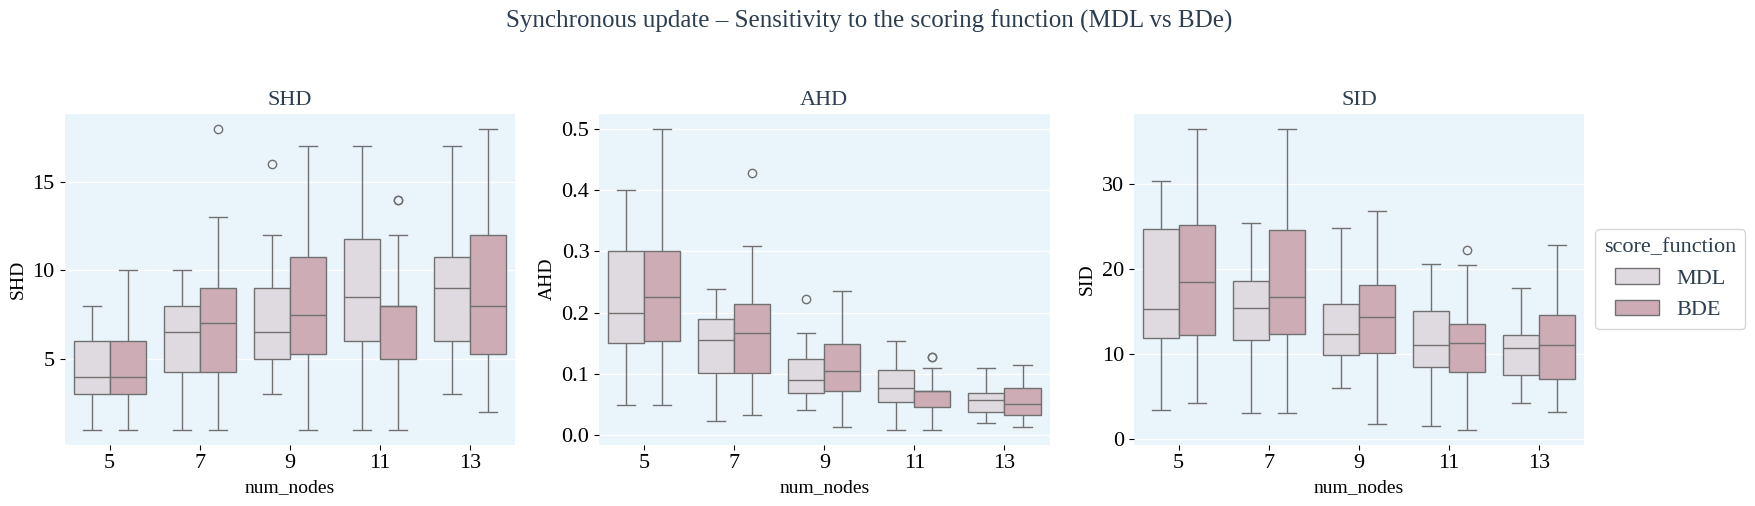

/home/maxi7524/repositories/SAD2_final_project/src/sad2_final_project/analysis/analysis.py:945: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxplot(
/home/maxi7524/repositories/SAD2_final_project/src/sad2_final_project/analysis/analysis.py:945: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxplot(
/home/maxi7524/repositories/SAD2_final_project/src/sad2_final_project/analysis/analysis.py:945: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxplot(


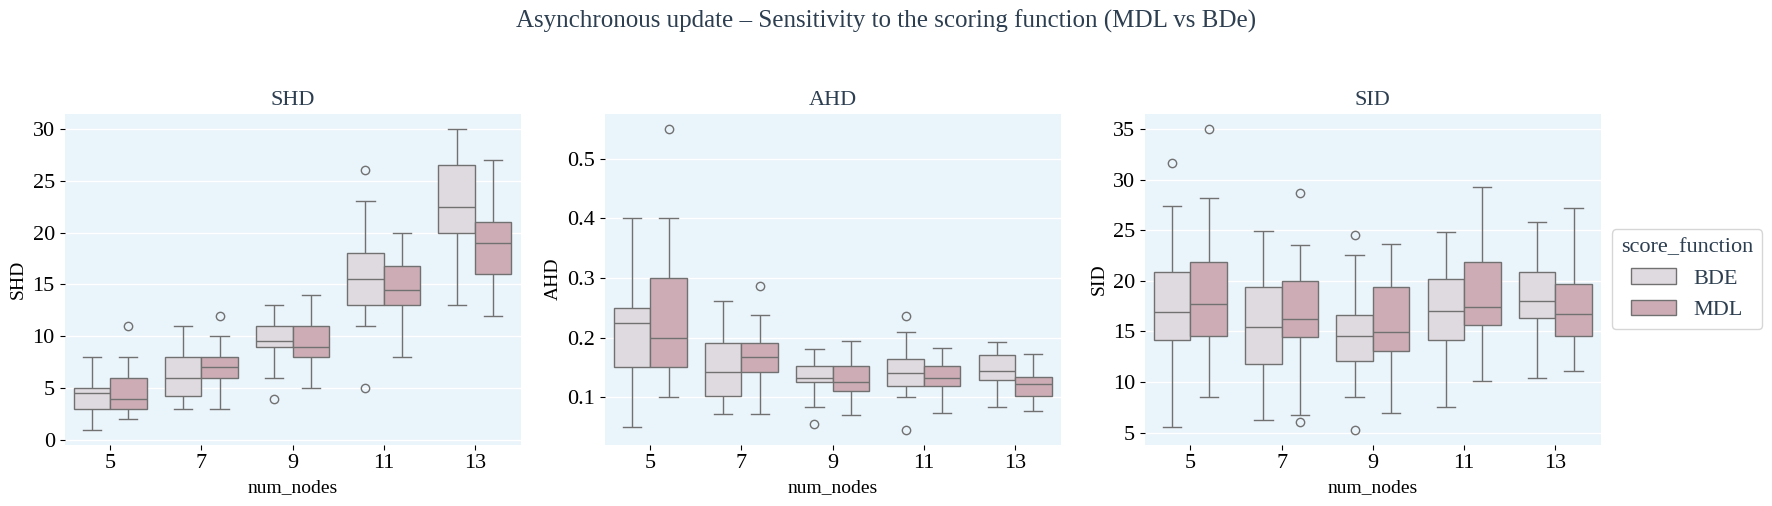

In [26]:
# parameters

metrics = ["SHD", "AHD", "SID"]

# ---------------------
# asynchronous case
# ---------------------

# Przygotowujemy jedną figurę z 3 kolumnami
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for i, metric in enumerate(metrics):
    df_long = dfs_exp4.melt(
        id_vars=["num_nodes", "score_function"], 
        value_vars=[metric], 
        var_name="metric", 
        value_name="metric_value"
    )

    # Rysujemy boxplot
    plot_boxplot(
        df=df_long,
        x="num_nodes",
        y="metric_value",
        hue="score_function",
        title=metric,
        ax=axes[i],
        show_legend=(i == 2),
        y_label=metric
    )

fig.suptitle(
    "Synchronous update – Sensitivity to the scoring function (MDL vs BDe)", 
    fontsize=18, y=1.02
)
plt.tight_layout()
plt.show()

# ---------------------
# asynchronous case
# ---------------------

# Przygotowujemy jedną figurę z 3 kolumnami
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for i, metric in enumerate(metrics):
    df_long = dfa_exp4.melt(
        id_vars=["num_nodes", "score_function"], 
        value_vars=[metric], 
        var_name="metric", 
        value_name="metric_value"
    )

    # Rysujemy boxplot
    plot_boxplot(
        df=df_long,
        x="num_nodes",
        y="metric_value",
        hue="score_function",
        title=metric,
        ax=axes[i],
        show_legend=(i == 2),
        y_label=metric
    )

fig.suptitle(
    "Asynchronous update – Sensitivity to the scoring function (MDL vs BDe)", 
    fontsize=18, y=1.02
)
plt.tight_layout()
plt.show()

#### Results

Analysis of reconstruction performance across different network sizes reveals distinct trends for the three evaluated metrics.


##### Both
**Structural Hamming Distance (SHD):**

In both cases median SHD is rising. This reflects the absolute number of edge modifications required to match the true network, which naturally grows as networks become larger and more complex.

**Adjusted Hamming Distance (AHD):** 

In both cases We observe low AHD median. Here also MDL score function have slightly better results (color is switched). The median is decreasing with size of network because of normalization, in smaller networks fewer amount FP makes bigger differences in metric
 

**Structural Intervention Distance (SID):** 

We can observe that synchronous update obtain better results, this due lower complexity. In synchronous case we se SID median is decreasing. In  asynchronous case we similiar relation but it is more blurry.

This may suggests that larger networks, despite having more nodes, show fewer errors in predicted causal effects relative to the total number of node pairs. 



##### Conclusion

**Comparison of synchronous and asynchronous update mode**

We can see that in most cases MDL have lower median in AHD and SHD value in synchronous update case.

In case of asynchronous we see that BDE have slightly worse results in AHD, btu slightly better in SID which is more important. To show it we would need additional tests.


**Model reconstruction differences**

We can that for our parameters We obtain better results in comparison to previous experiments (1, 2) where for AHD we obtain vales mostly between 0.2-0.3 with bigger 75 quantile and for SID we were obtaining results between 20-30. 






## Part 2 – Comparison Between Results

### Methodology

The goal is to assess whether the observed differences between results are statistically significant.

We compare the **median difference** between the baseline dataset
([Joined datasets 1 and 1.1](#dataset-1-baseline-dataset))
and the dataset sampled with optimal parameters
([dataset 2](#dataset-2-normalization-study)).

A **one-sided Wilcoxon signed-rank test** is applied.
Each group consists of approximately **5,400/9900/38000 paired observations**. 

For interpretation, the observed differences are additionally related to the **reference range defined by the median divided by the quantile values $Z[p]$ for $p = 0.25$ and $p = 0.75$**, i.e. the range 
$$ 
\text{median} / Z[p], \quad p \in {0.25, 0.75}.
$$ 

***

## Results

### Synchronous Networks

#### SHD

We observe a clear improvement, corresponding to a reduction of approximately **10 edges**, particularly visible for larger networks. Such big difference may caused by overfitted data in first example. We maybe choose to big normalization $k$ value.

***

#### AHD

| Scoring function | Mean improvement | Median improvement | Relative improvement / (median / $Z[p]$) |
| ---------------- | ---------------- | ------------------ | -------------------- |
| MDL              | 0.07             | 0.07               | 16% – 35%            |
| BDE              | 0.05             | 0.06               | 13% – 30% (median)   |

The results are statistically significantly better for both scoring functions.

***

#### SID

| Scoring function | Mean improvement | Median improvement | Relative improvement / (median / $Z[p]$) |
| ---------------- | ---------------- | ------------------ | -------------------- |
| MDL              | 3.26             | 1.36               | 2% – 6% (median)     |
| BDE              | 4.93             | 3.60               | 7% – 18% (median)    |

Across all variants, the obtained results are statistically significantly better.

***


### Asynchronous Networks

#### SHD

For the **BDE** scoring function, we observe significantly lower SHD values.
For **MDL**, worse results are obtained for larger networks.

***


#### AHD

| Scoring function | Mean difference | Median difference | Relative improvement / (median / $Z[p]$)        |
| ---------------- | --------------- | ----------------- | --------------------- |
| BDE              | 0.02            | 0.02              | 6% – 13%              |
| MDL              | –               | –                 | no significant change |

The observed difference for AHD is small and statistically significant only for the BDE metric.

***


#### SID

| Scoring function | Mean difference | Median difference | Relative improvement (median / $Z[p]$)         |
| ---------------- | --------------- | ----------------- | -------------------------------------------- |
| BDE              | −2.5            | −1.5              | 4% – 8% (median), 7% – 14% (mean) |
| MDL              | –               | –                 | 1% – 2%                                      |

The improvement is evaluated relative to the **reference range defined by median / $Z[p]$ for $p = 0.25$ and $p = 0.75$**. 

***


## Conclusion

We obtain **statistically significantly better results** for both **BDE** and **MDL** scoring functions across all sizes of Boolean networks.

***





Numerical comparisons

In [92]:
# parameters
metrics= ["SHD", "AHD", "SID"]
optimal_var = 'optimal_setting'

## merge all datasets
final_df = pd.concat([df, dfs, dfa], axis=0)


df_wilcoxon_final = compute_wilcoxon_table(
    final_df,
    metrics=metrics,
    transitions=[(0, 1)],
    group_cols=('update_mode', 'score_function', 'num_nodes'),
    sf_col=optimal_var,
    alternative='greater'
)

df_wilcoxon_final

metric  sf_from  sf_to transition  n_pairs  wilcoxon_stat        p_value  \
0     SHD        0      1        0→1    37800    341124728.5   0.000000e+00   
1     AHD        0      1        0→1    37800    342345533.5   0.000000e+00   
2     SID        0      1        0→1    37770    412670644.5  1.864524e-177   
3     SHD        0      1        0→1    37800    367235317.0   0.000000e+00   
4     AHD        0      1        0→1    37800    367832026.0   0.000000e+00   
5     SID        0      1        0→1    37800    434653048.0  1.701650e-308   
6     SHD        0      1        0→1    46800    616502714.0   0.000000e+00   
7     AHD        0      1        0→1    46800    616706191.0   0.000000e+00   
8     SID        0      1        0→1    46800    683380255.0   0.000000e+00   
9     SHD        0      1        0→1    27000    223143763.5   0.000000e+00   
10    AHD        0      1        0→1    27000    223256646.5   0.000000e+00   
11    SID        0      1        0→1    27000    220518892.0  1.804326e-198   
12    SHD        0      1        0→1    36000    414012146.5   0.000000e+00   
13    AHD        0      1        0→1    36000    414109005.0   0.000000e+00   
14    SID        0      1        0→1    36000    413046886.0   0.000000e+00   
15    SHD        0      1        0→1    37800    286251297.5   2.408406e-15   
16    AHD        0      1        0→1    37800    286329958.5   1.279150e-14   
17    SID        0      1        0→1    37800    400390216.0  5.637319e-117   
18    SHD        0      1        0→1    37800    265397275.5   1.000000e+00   
19    AHD        0      1        0→1    37800    267710713.0   1.000000e+00   
20    SID        0      1        0→1    37800    365503247.0   1.115097e-06   
21    SHD        0      1        0→1    46800    457451605.0   4.574146e-01   
22    AHD        0      1        0→1    46800    458314641.0   3.843880e-01   
23    SID        0      1        0→1    46800    608587916.0  5.807663e-102   
24    SHD        0      1        0→1    27000    135866627.0   1.000000e+00   
25    AHD        0      1        0→1    27000    134932190.5   1.000000e+00   
26    SID        0      1        0→1    27000    173558948.0   1.000000e+00   
27    SHD        0      1        0→1    36000    270500303.0   1.000000e+00   
28    AHD        0      1        0→1    36000    269312966.5   1.000000e+00   
29    SID        0      1        0→1    36000    348015534.0   2.807506e-35   
30    SHD        0      1        0→1     5400      8834747.5  1.184873e-197   
31    AHD        0      1        0→1     5400      8813433.0  6.570815e-190   
32    SID        0      1        0→1     5400      7553417.5   4.304460e-03   
33    SHD        0      1        0→1     5400      7049279.0   1.240443e-12   
34    AHD        0      1        0→1     5400      7003207.0   5.742470e-11   
35    SID        0      1        0→1     5400      6222804.0   1.000000e+00   
36    SHD        0      1        0→1     9900     39408123.5   0.000000e+00   
37    AHD        0      1        0→1     9900     39358125.0   0.000000e+00   
38    SID        0      1        0→1     9900     40405685.5   0.000000e+00   
39    SHD        0      1        0→1     5400      8661509.0  7.049785e-109   
40    AHD        0      1        0→1     5400      8718111.0  4.892230e-114   
41    SID        0      1        0→1     5400      8780351.0   1.530256e-39   
42    SHD        0      1        0→1     9900     40230002.0   0.000000e+00   
43    AHD        0      1        0→1     9900     40253946.0   0.000000e+00   
44    SID        0      1        0→1     9900     40414266.5   0.000000e+00   
45    SHD        0      1        0→1     5400      9972161.5   0.000000e+00   
46    AHD        0      1        0→1     5400     10066382.5   0.000000e+00   
47    SID        0      1        0→1     5400      9715465.0  1.880149e-107   
48    SHD        0      1        0→1     5400      9432618.0  3.026924e-223   
49    AHD        0      1        0→1     5400      95

In [90]:


updates = ['synchronous', 'asynchronous']
scores = ['BDE', 'MDL']

rows = []

for metric in metrics:
    for update in updates:
        for score in scores:
            subset = df_wilcoxon_final[
                (df_wilcoxon_final['metric'] == metric) &
                (df_wilcoxon_final['update_mode'] == update) &
                (df_wilcoxon_final['score_function'] == score)
            ]['median_diff']

            if subset.empty:
                continue

            rows.append({
                'metric': metric,
                'update_mode': update,
                'score_function': score,
                'mean': subset.mean(),
                'median': subset.median(),
                'q25': subset.quantile(0.25),
                'q75': subset.quantile(0.75),
                'IQR': subset.quantile(0.75) - subset.quantile(0.25)
            })

stats_df = pd.DataFrame(rows)

stats_df_formatted = stats_df.copy()

float_cols = ['mean', 'median', 'q25', 'q75', 'IQR']
stats_df_formatted[float_cols] = stats_df_formatted[float_cols].round(4)

condition = (stats_df_formatted['metric'] == 'SID') & (stats_df_formatted['update_mode'] == 'asynchronous')
stats_df_formatted[condition]


metric   update_mode score_function    mean  median     q25     q75     IQR
10    SID  asynchronous            BDE -1.5875 -1.6359 -1.8284 -1.3722  0.4561
11    SID  asynchronous            MDL -0.4220 -0.4043 -0.6771 -0.0637  0.6134

In [79]:
rows = []

for metric in metrics:
    for update in final_df['update_mode'].unique():
        subset = final_df.loc[
            (final_df[optimal_var] == False) &
            (final_df['update_mode'] == update),
            metric
        ]

        if subset.empty:
            continue

        q25 = subset.quantile(0.25)
        q75 = subset.quantile(0.75)

        rows.append({
            'metric': metric,
            'update_mode': update,
            'q25': q25,
            'q75': q75,
            'IQR': q75 - q25
        })

quantiles_update_df = pd.DataFrame(rows)

quantiles_update_df[['q25', 'q75', 'IQR']] = (
    quantiles_update_df[['q25', 'q75', 'IQR']].round(4)
)

quantiles_update_df.sort_values(['metric', 'update_mode'])




metric   update_mode      q25      q75      IQR
3    AHD  asynchronous   0.1528   0.3000   0.1472
2    AHD   synchronous   0.2000   0.4306   0.2306
1    SHD  asynchronous   8.0000  20.0000  12.0000
0    SHD   synchronous   9.0000  27.0000  18.0000
5    SID  asynchronous  17.6519  27.6783  10.0264
4    SID   synchronous  20.0128  48.6860  28.6732

In [91]:
# 0.06 / np.array([0.2, 0.4306])	
# mean: -0.422	median-0.4043	
# 0.02 / np.array([0.1528, 0.3])
0.4043 / np.array([17.6519, 27.6783])

# 3.6 / np.array([20.0128, 48.686])

array([0.02290405, 0.01460711])

Plots

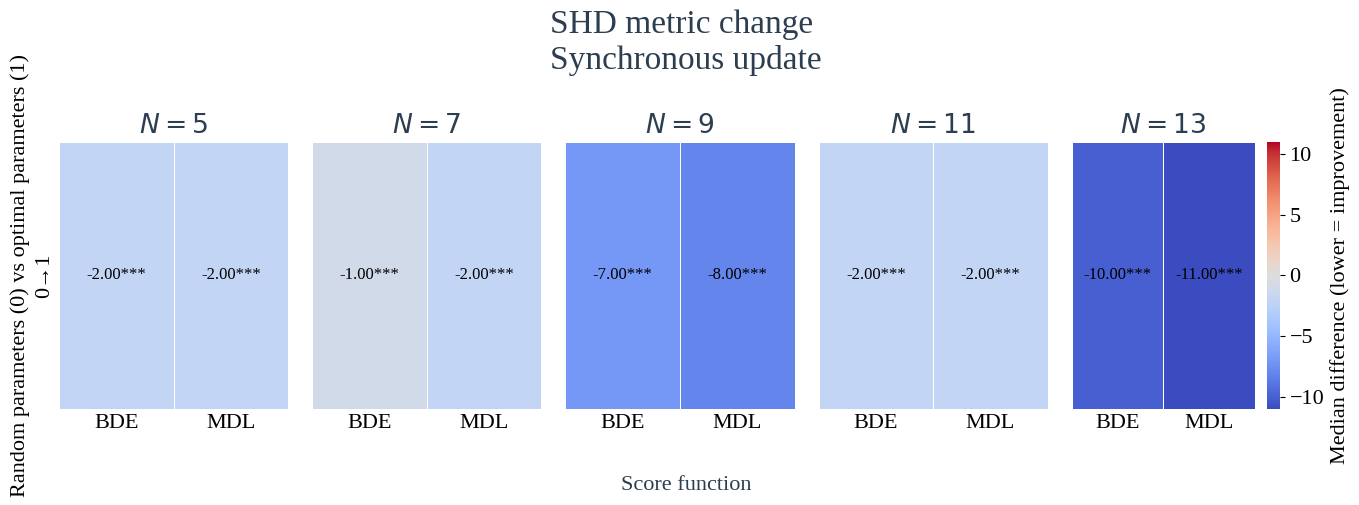

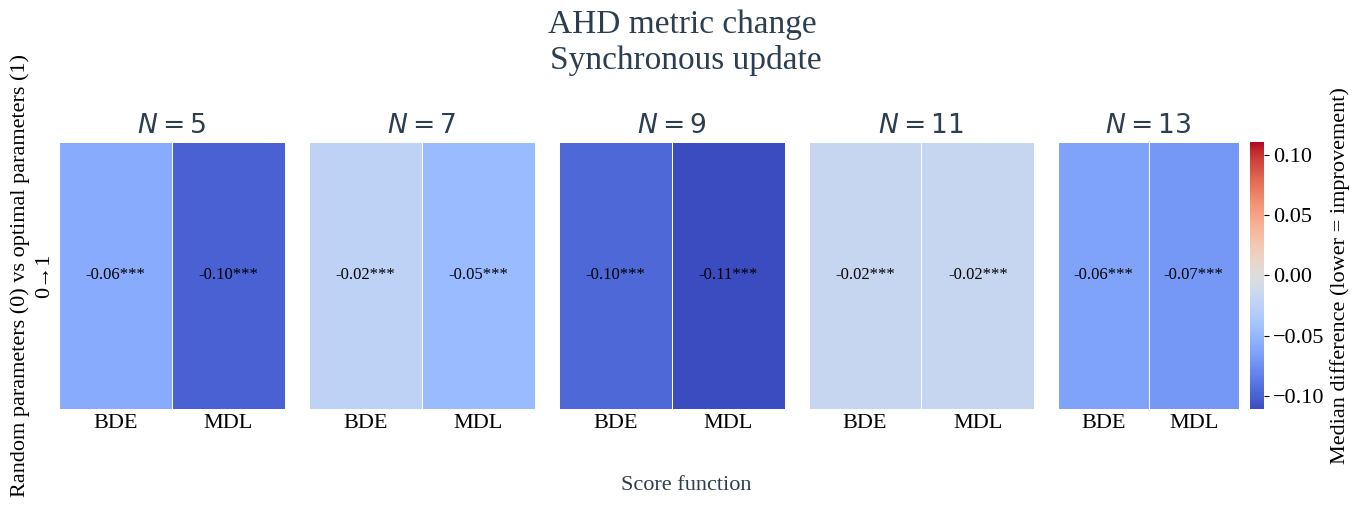

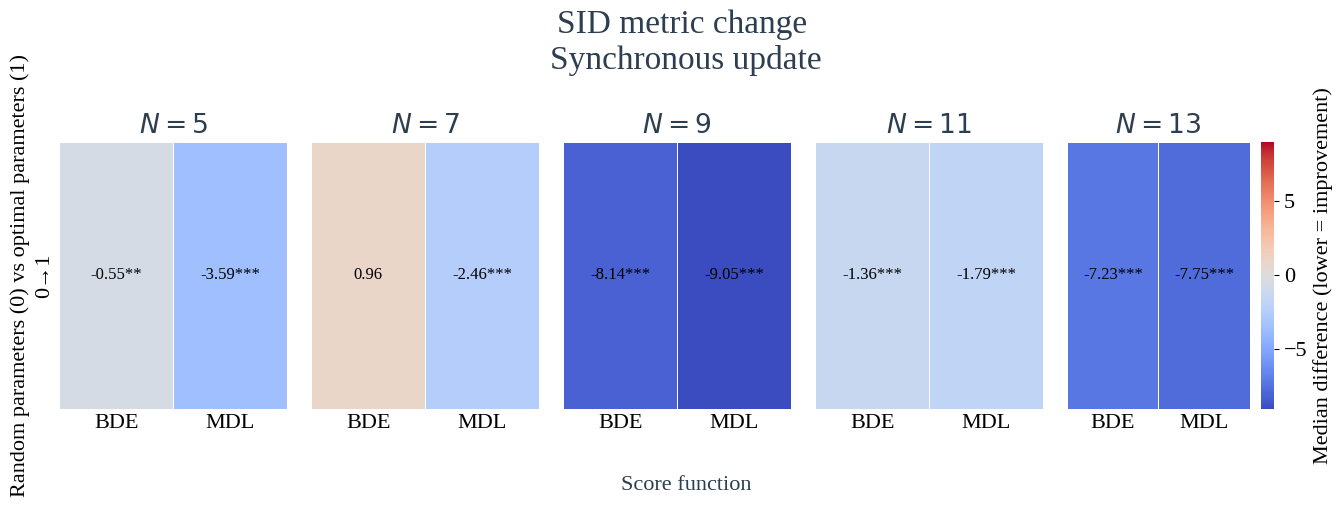

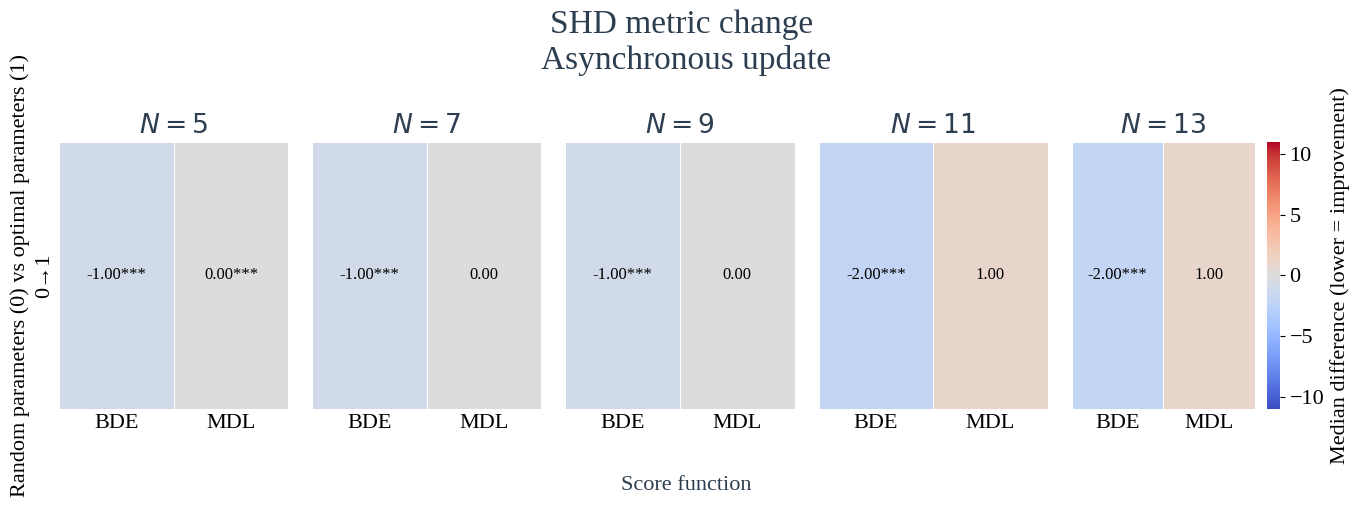

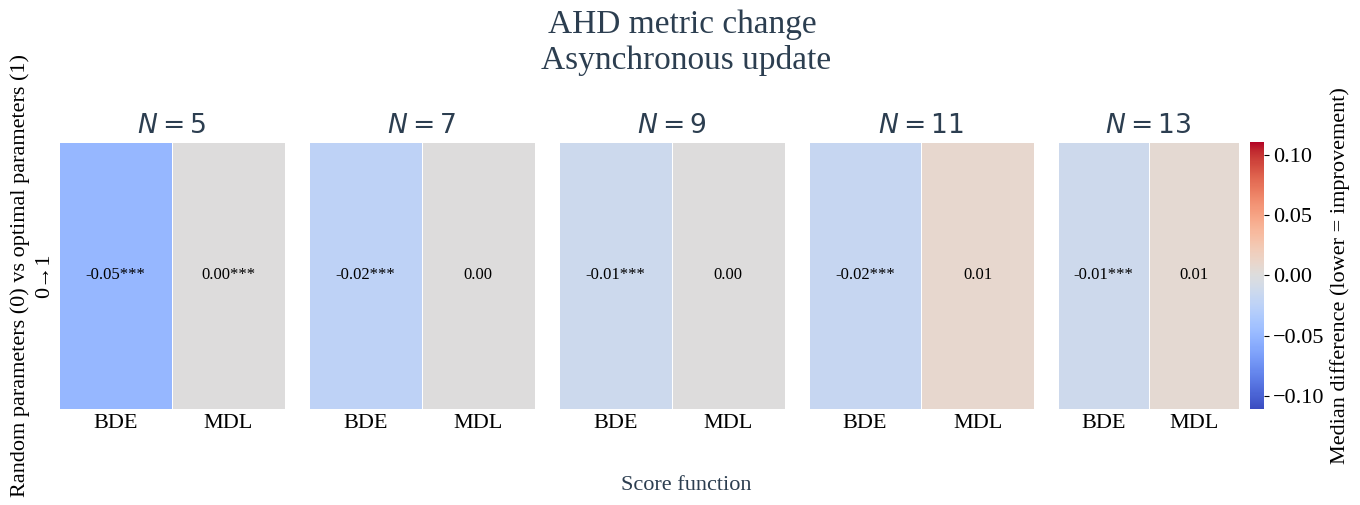

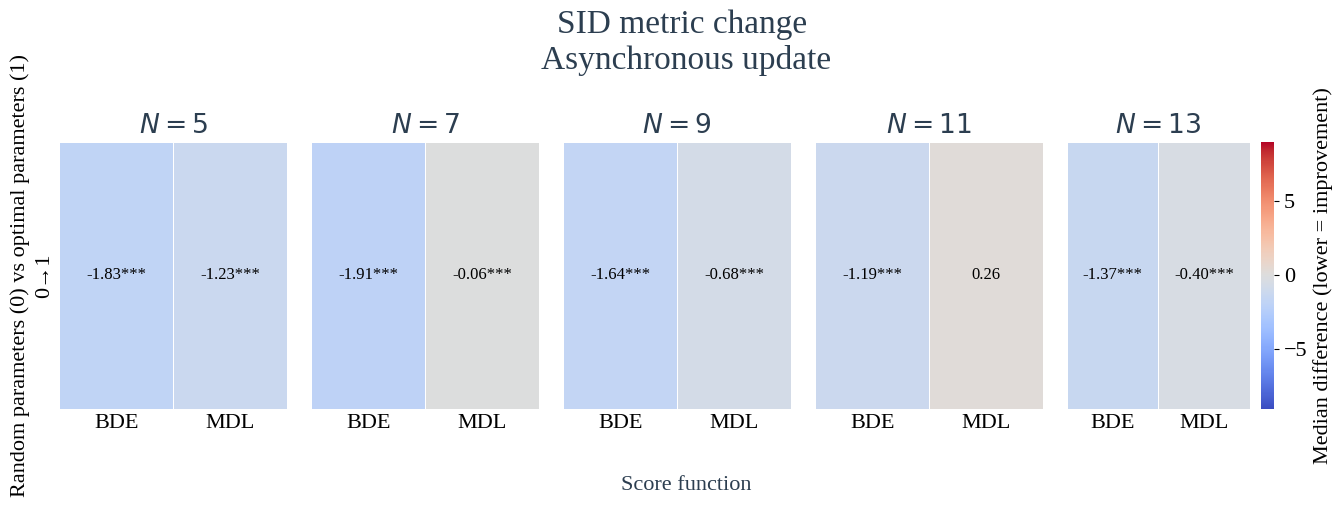

In [48]:


# values preparation
## Creating transition order (special sign) 
transitions_order = sorted(df_wilcoxon_final['transition'].unique(), 
       key = lambda x: int(x.split('→')[0]),
       reverse=True)
## get list of nodes
num_nodes_list = df_wilcoxon_final['num_nodes'].unique()

# Metric adjustment loop
for update_mode in ['synchronous', 'asynchronous']:
    for metric in metrics:
        ## common scale
        df_m = df_wilcoxon_final[df_wilcoxon_final["metric"] == metric]
        abs_max = np.nanmax(np.abs(df_m["median_diff"]))
        vmin, vmax = -abs_max, abs_max
        fig, axes = plt.subplots(1, 5, figsize=(14, 5), sharey=True)
        ## Single heatmap loop
        for i, num_nodes in enumerate(num_nodes_list):
            ### filt node value 
            filt = df_wilcoxon_final['num_nodes'] == num_nodes
            ### add num_nodes plot 
            plot_wilcoxon_heatmap(
                #### values
                df_wilcoxon_final[filt],
                metric=metric,
                update_mode=update_mode,
                transitions_order=transitions_order,
                #### plot settings
                ax=axes[i],
                cbar=False if i < len(num_nodes_list) - 1 else True,
                vmin=vmin,
                vmax=vmax,
                ylabel = 'Random parameters (0) vs optimal parameters (1)',
            )

            ### set labels
            #### set subplot label
            axes[i].set_title(f"$N = {num_nodes}$")
            ### remove y labels on inner subplots
            if i != 0:
                axes[i].set_ylabel("")  # usuwa "Sampling frequency" z pozostałych
            #### remove singular  
            axes[i].set_xlabel("")     # usuwa "Score function"

        # figure settings
        ## labels
        fig.suptitle(f'{metric} metric change \n{update_mode.capitalize()} update', fontsize=24)
        fig.supxlabel("Score function", fontsize=16)    

        # plot
        plt.tight_layout()
        plt.show()


# Part 2

In this part we will check if our results are sensible.

## Model Selection
A validated Boolean network model was selected from the Biodivine Boolean Models repository (https://github.com/sybila/biodivine-boolean-models), with the number of nodes not exceeding 16. For this study, the following model was used:

- **Model:** ERBB signaling network
- **Source:** Biodivine repository ([model.bnet](download_models/model_id_37/model.bnet))
- **Number of nodes:** 11

## Results
- The metrics medians exhibited third quantile, that is maybe to do higher complexity which is out of range of our experiment 

## Conclusions
- We obtain very low attractor ratio
- In tests we also obtain improvement of metrics values, on real network we do not see similar results but we also do not posses data about original results of evaluation. 

In [31]:
MODEL_NAME = "model_id_37_merged"
MODELS_PATH = Path("download_models")

EXPERIMENT_PATH = DATA_PATH  / MODEL_NAME / 'model_id_37_merged_metrics.csv'
model_id_37_results = pd.read_csv(EXPERIMENT_PATH)
# bn = load_bnet_to_BN(MODELS_PATH / MODEL_NAME / "model.bnet")
model_id_37_results

condition_id_num score_function  dataset_succeeded  attractor_ratio  TP  \
0  model_id_37_MDL            MDL               True         0.165854  11   
1  model_id_37_BDE            BDE               True         0.230938  18   

    FP  FN        f1  accuracy  precision    recall  sensitivity       AHD  \
0   69  34  0.176000  0.570833   0.137500  0.244444     0.244444  0.429167   
1  120  27  0.196721  0.387500   0.130435  0.400000     0.400000  0.612500   

   SHD  EHD        SID  log_likelihood           MDL           BDe  
0  103   79  51.726523    16903.306657  19883.333840  13860.752624  
1  147   94  46.702006     8083.718784  50996.110213  11941.102365